<center><h1>Step 0 - Preprocessing</h1></center> 

In this section, we first read the data including the bug reports and source code files of all 12 projects and for ease of access, we save them as two pickle files in the ./Data directory. Therefore, this set of code will populate the ./Data directory with "allBugReports.pickle" which is a pandas dataframe that contains all the bug reports from all projects and "allSourceCodes.pickle" which is a pandas dataframe that contains all source files after preprocessing.

### Required Libraries

In [1]:
!pip install javalang

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import warnings
import javalang
import re
import glob
import math
import time
from scipy import spatial
import scipy.spatial.distance
import xml.etree.ElementTree as ET
import requests
import multiprocessing
from tqdm import tqdm_notebook
from time import gmtime, strftime
from random import randint
warnings.simplefilter(action='ignore', category=FutureWarning)

<center><h1>Splitting code and natural language</h1></center> 

In [3]:
def classNames_methodNames(node):
    result=''
    if isinstance(node,javalang.tree.MethodDeclaration) or isinstance(node,javalang.tree.ClassDeclaration):
        return node.name.lower()+' '
    if not (isinstance(node,javalang.tree.PackageDeclaration) or
        isinstance(node,javalang.tree.FormalParameter) or
       isinstance(node,javalang.tree.Import)):
        if node:
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=classNames_methodNames(childNode)
    return result
    
def traverse_node(node,i=0):
    i+=1
    result=''
    if not(isinstance(node,javalang.tree.PackageDeclaration)
            or isinstance(node,javalang.tree.FormalParameter)            
            or isinstance(node,javalang.tree.Import)
            or isinstance(node,javalang.tree.CompilationUnit)):
        if node:
            if (isinstance(node,int) or isinstance(node,str) or isinstance(node,float)) and i==2:
                result+=node+' '
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=traverse_node(childNode,i)
    return result

def code_parser(code):
    try:
        tree = javalang.parse.parse(code)
        return ''.join([traverse_node(node) for path, node in tree]) + ' ' + ''.join([classNames_methodNames(node)
                                                                                      for path, node in tree])
    except Exception as e: 
        print(e)
        return ''


def loadSourceFiles2df(PATH,group,project):
    """
    Receives: group name and project name 
    Process: open the source file directory and finds all the java files,
             and after preprocessing(using code_preprocessor) load them into a pandas dataframe 
    Returns: dataframe >> "filename","code","size"
    """
    print('Loading source files of {} from group:{} ...'.format(project,group))
    PATH=os.path.join("data",group,project,"gitrepo")
    all_source_files=glob.glob(PATH+'/**/*.java', recursive=True)
    source_codes_df=pd.DataFrame([])
    sourceCodesList=[]

    for filename in tqdm_notebook(all_source_files):
        code=open(filename,encoding='ISO-8859-1').read()
        if 'src/' in filename:
            sourceCodesList.append(dict({"filename":filename.split('src/')[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
        else:
            sourceCodesList.append(dict({"filename":filename.split(project)[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
    source_codes_df=source_codes_df.append(pd.DataFrame(sourceCodesList))
    return source_codes_df

def load_all_SCs(dataPath):
    print('\tLoading all source codes ... ')
    source_codes_df=pd.DataFrame([])
    all_groups=[folder for folder in listdir(dataPath)]
    for group in tqdm_notebook(all_groups):
        all_projects= [folder for folder in listdir(os.path.join(dataPath,group))]
        for project in all_projects:
            source_path=os.path.join(dataPath,group,project,"gitrepo")
            source_codes_df=source_codes_df.append(loadSourceFiles2df(source_path,group,project))
    return source_codes_df

<center><h1>Loading bug reports pandas Dataframe</h1></center> 

In [4]:
def loadBugs2df(PATH,project):
    """
    @Receives: the path to bug repository (the xml file)
    @Process: Parses the xml file and reads the fix files per bug id. 
    @Returns: Returns the dataframe
    """
    print("Loading Bug reports ... ")
    all_bugs_df=pd.DataFrame([],columns=["id","fix","text","fixdate"])
    bugRepo = ET.parse(PATH).getroot()
    buglist=[]                   
    for bug in tqdm_notebook(bugRepo.findall('bug')):
        bugDict=dict({"id":bug.attrib['id'],"fix":[],"fixdate":bug.attrib['fixdate']
                      ,"summary":None,"description":None,"project":project,"average_precision":0.0})
        for bugDetail in bug.find('buginformation'):
            if bugDetail.tag=='summary':
                bugDict["summary"]=bugDetail.text
            elif bugDetail.tag=='description':
                bugDict["description"]=bugDetail.text
        bugDict["fix"]=np.array([fixFile.text.replace('/','.').lower() for fixFile in bug.find('fixedFiles')])
        summary=str(bugDict['summary']) if str(bugDict['summary']) !=np.nan else ""
        description=str(bugDict['description']) if str(bugDict['description']) !=np.nan else ""
        buglist.append(bugDict)
    all_bugs_df=all_bugs_df.append(pd.DataFrame(buglist))
    return all_bugs_df.set_index('id')

def load_all_BRs(dataPath):
    print('\tLoading all bug reports ... ')
    all_bugs_df=pd.DataFrame([])
    all_groups=[folder for folder in listdir(dataPath)]
    for group in tqdm_notebook(all_groups):
        all_projects= [folder for folder in listdir(os.path.join(dataPath,group))]
        for project in all_projects:
            print("load_all_BRs dataPath: ", dataPath)
            print("load_all_BRs group: ", group)
            print("load_all_BRs project: ", project)
            data_path=os.path.join(dataPath,group,project,"bugrepo","repository.xml")
            print("load_all_BRs data_path: ", data_path)
            all_bugs_df=all_bugs_df.append(loadBugs2df(data_path,project))
            print(len(all_bugs_df))
    return all_bugs_df




<center><h1>Main Preprocessing class</h1></center> 

In [5]:
class PreprocessingUnit:

    all_projects_source_codes=pd.DataFrame([])
    all_projects_bugreports=pd.DataFrame([])
    
    def __init__(self,dataPath):

        self.dataPath=dataPath
        self.dataFolder=os.path.join(os.getcwd(),'Output')
        if not os.path.exists(self.dataFolder):
            os.makedirs(self.dataFolder)
            
    def execute(self):

        self.loadEverything()

    def loadEverything(self):
        vectorize=False
        if PreprocessingUnit.all_projects_bugreports.empty:
            bugReportFile=os.path.join(self.dataFolder,'allBugReports.pickle')
            if not os.path.isfile(bugReportFile):
                print("self.dataPath: ", self.dataPath)
                PreprocessingUnit.all_projects_bugreports=load_all_BRs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_bugreports.to_pickle(bugReportFile, protocol=4)
            else: 
                PreprocessingUnit.all_projects_bugreports=pd.read_pickle(bugReportFile)
        print("*** All bug reports are are preprocessed and stored as: {} ***".format('/'.join(bugReportFile.split('/')[-2:])))

        if PreprocessingUnit.all_projects_source_codes.empty:
            sourceCodeFile=os.path.join(self.dataFolder,'allSourceCodes.pickle')
            if not os.path.isfile(sourceCodeFile):
                PreprocessingUnit.all_projects_source_codes=load_all_SCs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_source_codes.to_pickle(sourceCodeFile, protocol=4)
            else:
                PreprocessingUnit.all_projects_source_codes=pd.read_pickle(sourceCodeFile)
        print("*** All source codes are preprocessed and stored as: {} ***".format('/'.join(sourceCodeFile.split('/')[-2:])))
        

### MAIN

In [6]:
if __name__=="__main__":

    config={'DATA_PATH':os.path.join('data')}
    preprocessor=PreprocessingUnit(dataPath=config['DATA_PATH'])
    preprocessor.execute()
   


*** All bug reports are are preprocessed and stored as: C:\Users\Joseph\Desktop\544\Project Final\Output\allBugReports.pickle ***
*** All source codes are preprocessed and stored as: C:\Users\Joseph\Desktop\544\Project Final\Output\allSourceCodes.pickle ***


In [7]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(all_projects_bugreports.iloc[0])
display(all_projects_source_codes.iloc[0].unprocessed_code)

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


fix                  [org.apache.commons.collections.map.flat3map.j...
text                                                               NaN
fixdate                                            2006-07-18 22:02:11
summary              Flat3Map.Entry.setValue() overwrites other Ent...
description          Flat3Map&amp;apos;s Entry objects will overwri...
project                                                    COLLECTIONS
average_precision                                                    0
Name: 217, dtype: object

'/*\n *  Licensed to the Apache Software Foundation (ASF) under one or more\n *  contributor license agreements.  See the NOTICE file distributed with\n *  this work for additional information regarding copyright ownership.\n *  The ASF licenses this file to You under the Apache License, Version 2.0\n *  (the "License"); you may not use this file except in compliance with\n *  the License.  You may obtain a copy of the License at\n *\n *      http://www.apache.org/licenses/LICENSE-2.0\n *\n *  Unless required by applicable law or agreed to in writing, software\n *  distributed under the License is distributed on an "AS IS" BASIS,\n *  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n *  See the License for the specific language governing permissions and\n *  limitations under the License.\n */\npackage org.apache.commons.collections;\n\nimport java.util.ArrayList;\nimport java.util.EmptyStackException;\n\n/**\n * An implementation of the {@link java.util.Stack}

In [8]:
!pip install progressbar2

In [9]:
from typing import *
import progressbar

In [10]:
# convert ids (column which isn't unique) to int64
all_projects_bugreports.index = all_projects_bugreports.index.astype(int)
all_projects_source_codes.index = all_projects_source_codes.index.astype(int)

In [11]:
all_projects_bugreports = all_projects_bugreports.reset_index()

In [12]:
all_projects_bugreports.head()

,id,fix,text,fixdate,summary,description,project,average_precision
0,217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
1,214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
2,222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
3,261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
4,264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0


In [13]:
pd.set_option('display.max_colwidth', 1000)

In [14]:
all_projects_source_codes.head(1)

,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collections\arraystack.java,"/*\n * Licensed to the Apache Software Foundation (ASF) under one or more\n * contributor license agreements. See the NOTICE file distributed with\n * this work for additional information regarding copyright ownership.\n * The ASF licenses this file to You under the Apache License, Version 2.0\n * (the ""License""); you may not use this file except in compliance with\n * the License. You may obtain a copy of the License at\n *\n * http://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an ""AS IS"" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\npackage org.apache.commons.collections;\n\nimport java.util.ArrayList;\nimport java.util.EmptyStackException;\n\n/**\n * An implementation of the {@link java.util.Sta...",COLLECTIONS


<center><h1> More Pre-processing (Team 7) </h1></center> 

## Function Declaration: For every bug report and source file do:
	• Remove JAVA keywords, separators, and operators.
	• Remove punctuation and whitespace.
	• Split variables names into separate constituent words and convert to lowercase.
		○ "TypeDeclaration" = "type", "declaration"
		○ "isCommitable" = "is", "commitable"
	• Remove english stop words.
	• Use Porter Stemming Algorithm to stem words.


In [15]:
import re, string
from nltk.stem.snowball import *
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from javalang import tokenizer

def remove_java_tokens(text: str) -> str:
    """Removing Java Tokens which means keywords, operators, and seperators

    Parameters
    ----------
    text : str
        Java Code string. 

    Returns
    -------
    str
        String with no java keywords, operators, and seperators.

    """
    
    JAVA_KEY_WORDS: Set[str] = tokenizer.Keyword.VALUES 
    JAVA_SEPARATORS: Set[str] = tokenizer.Separator.VALUES 
    JAVA_OPERATORS: Set[str] = tokenizer.Operator.VALUES
    
    new_text: str = text
        
    for key_word in JAVA_KEY_WORDS:
        new_text = new_text.replace(key_word, ' ')
    for separator in JAVA_SEPARATORS:
        new_text = new_text.replace(separator, ' ')
    for operator in JAVA_OPERATORS:
        new_text = new_text.replace(operator, ' ')
    
    return new_text

def remove_punctuation_and_whitespace(text: str) -> str:
    """Removing all punctuation and whitespaces from string

    Parameters
    ----------
    param1 : str
        string that has/does not have punctuation and/or whitespaces 

    Returns
    -------
    str
        String with no punctuation or whitespaces
    """ 
    
    # 1. Remove all of the punctuations (use string.punctuation and str.translate)
    # 2. Replace repetetive whitespaces with just one blank character (e.g.: 'i had \tan apple' -> 'i had an apple')
#     text = re.sub(r'\\s', '', text)
    words: List[str] = [word.strip() for word in text.translate(str.maketrans('', '', string.punctuation.replace('_',''))).strip().split()]
    new_text: str = ' '.join(words)
    return new_text

def split_variables_into_constituent_names(text: str) -> str:
    """Split string by constituents: camel case or snake case

    Parameters
    ----------
    param1 : str
        string that is formatted like Java code. Some words will be formatted like varOne or var_One 

    Returns
    -------
    str
        String that has seperated into constituent
    """ 
    
    # if not snake case, then camelcase
    results: list = re.findall('[A-Z]+[^A-Z]*', text)
    if len(results) == 0:
        return text
    results = [word.strip().replace('_','') for word in results]
    
    # make results lowercase
    new_text: str = ' '.join(results).lower()
    return new_text

def remove_stop_words(text: str) -> str:
    """Remove stop words. Getting words to their root words

    Parameters
    ----------
    param1 : str
        String that has all their words in full form. 

    Returns
    -------
    str
        String that has removed stop words from string. 
    """
    words: List[str] = text.split()
    non_stop_words: List[str] = [word for word in words if word not in ENGLISH_STOP_WORDS]
    new_text: str = ' '.join(non_stop_words)
    return new_text

def stem_words(text: str) -> str:
    """Stem each word in the string using snowball

    Parameters
    ----------
    param1 : str
        String that is unstemmed

    Returns
    -------
    str
        String that has all its words stemmed
    """
    # E. Stem each word using snowball stemmer provided in nltk
    words: List[str] = text.split()
    stemmer = PorterStemmer()
    new_text: str = ' '.join([stemmer.stem(word) for word in words])
    return new_text

## Execute Functions: Test Pre-processing on Sample Input

In [16]:
pre_processing_funcs: List[Callable[[str], str]] = [remove_java_tokens, remove_punctuation_and_whitespace, split_variables_into_constituent_names, remove_stop_words, stem_words]

### Example: Use Bug Report Sample

In [17]:
test_str: str = str(all_projects_bugreports.iloc[0][['description']][0])
print("original: \n")
new_text: str = test_str
print(new_text)

for func in pre_processing_funcs:
    new_text = func(new_text)
    print(func.__name__, '\n')
    print(new_text, '\n')


original: 

Flat3Map&amp;apos;s Entry objects will overwrite other Entry&amp;apos;s values if Entry.setValue() is called on one.  It should only overwrite the Entry at hand.
I&amp;apos;ve looked at the source, and the case statement incorrectly falls through, rather than returning like it should:
Flat3Map.java, lines 646-660:
        public Object setValue(Object value) {
            if (canRemove == false) 
{
                throw new IllegalStateException(AbstractHashedMap.SETVALUE_INVALID);
            }
            Object old = getValue();
            switch (nextIndex) 
{
                case 3: 
                    parent.value3 = value;
                case 2:
                    parent.value2 = value;
                case 1:
                    parent.value1 = value;
            }
            return old;
        }
With this code, if I set the value of the third item in the EntrySet, then all three values are set to the new value.
remove_java_tokens 

Flat3Map amp apos s En  obj

### Example: Use Source Code Sample

In [18]:
test_str = str(all_projects_source_codes.iloc[0][['unprocessed_code']][0])
print("original: \n")
new_text: str = test_str
print(new_text)

for func in pre_processing_funcs:
    new_text = func(new_text)
    print(func.__name__, '\n')
    print(new_text, '\n')

original: 

/*
 *  Licensed to the Apache Software Foundation (ASF) under one or more
 *  contributor license agreements.  See the NOTICE file distributed with
 *  this work for additional information regarding copyright ownership.
 *  The ASF licenses this file to You under the Apache License, Version 2.0
 *  (the "License"); you may not use this file except in compliance with
 *  the License.  You may obtain a copy of the License at
 *
 *      http://www.apache.org/licenses/LICENSE-2.0
 *
 *  Unless required by applicable law or agreed to in writing, software
 *  distributed under the License is distributed on an "AS IS" BASIS,
 *  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 *  See the License for the specific language governing permissions and
 *  limitations under the License.
 */
package org.apache.commons.collections;

import java.util.ArrayList;
import java.util.EmptyStackException;

/**
 * An implementation of the {@link java.util.Stack} API that i

### Progress Reporting: Redirect sys.stdout to tqdm.write() for progress bars

In [19]:
!pip install tqdm

In [20]:
from time import sleep
import contextlib
import sys
from tqdm import tqdm
from tqdm.contrib import DummyTqdmFile

# link to original code for this context manager: https://github.com/tqdm/tqdm/#ipython-jupyter-integration
@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

## Apply Pre-preprocessing: To Bug Reports and Source Codes

In [21]:
all_projects_bugreports_valid: pd.DataFrame = all_projects_bugreports.drop(columns=['text']).dropna().reset_index()
all_projects_bugreports_valid['description_cleaned'] = all_projects_bugreports_valid['description']

num_steps: int = len(pre_processing_funcs)
max_progress: int = 100
progress_step: float = max_progress / num_steps
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    # tqdm needs the original stdout
    # and dynamic_ncols=True to autodetect console width
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Pre-processing bug reports") as pbar:
        for func in pre_processing_funcs:
            print("executing: " + func.__name__)
            all_projects_bugreports_valid['description_cleaned'] = all_projects_bugreports_valid['description_cleaned'].map(func)
            pbar.update(progress_step)
            print("finished:  " + func.__name__)
        
        

executing: remove_java_tokens                                                                                          
finished:  remove_java_tokens                                                                                          
executing: remove_punctuation_and_whitespace                                                                           
finished:  remove_punctuation_and_whitespace                                                                           
executing: split_variables_into_constituent_names                                                                      
finished:  split_variables_into_constituent_names                                                                      
executing: remove_stop_words                                                                                           
finished:  remove_stop_words                                                                                           
executing: stem_words                   

#### Note: stem_words pre-processing takes a long time on the source_code data

In [22]:
all_projects_source_codes_valid: pd.DataFrame = all_projects_source_codes.dropna()
all_projects_source_codes_valid['processed_code'] = all_projects_source_codes_valid['unprocessed_code']

num_steps: int = len(pre_processing_funcs)
max_progress: int = 100
progress_step: float = max_progress / num_steps
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    # tqdm needs the original stdout
    # and dynamic_ncols=True to autodetect console width
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Pre-processing source files") as pbar:
        for func in pre_processing_funcs:
            print("executing: " + func.__name__)
            all_projects_source_codes_valid['processed_code'] = all_projects_source_codes_valid['processed_code'].map(func)
            pbar.update(progress_step)
            print("finished:  " + func.__name__)

executing: remove_java_tokens                                                                                          
finished:  remove_java_tokens                                                                                          
executing: remove_punctuation_and_whitespace                                                                           
finished:  remove_punctuation_and_whitespace                                                                           
executing: split_variables_into_constituent_names                                                                      
finished:  split_variables_into_constituent_names                                                                      
executing: remove_stop_words                                                                                           
finished:  remove_stop_words                                                                                           
executing: stem_words                   

In [23]:
all_projects_source_codes_valid.head(1)

,filename,unprocessed_code,project,processed_code
0,\gitrepo\src\java\org\apache\commons\collections\arraystack.java,"/*\n * Licensed to the Apache Software Foundation (ASF) under one or more\n * contributor license agreements. See the NOTICE file distributed with\n * this work for additional information regarding copyright ownership.\n * The ASF licenses this file to You under the Apache License, Version 2.0\n * (the ""License""); you may not use this file except in compliance with\n * the License. You may obtain a copy of the License at\n *\n * http://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an ""AS IS"" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\npackage org.apache.commons.collections;\n\nimport java.util.ArrayList;\nimport java.util.EmptyStackException;\n\n/**\n * An implementation of the {@link java.util.Sta...",COLLECTIONS,licens apach softwar foundat asf contributor licens agreement notic file distribut work addit mation regard copyright ownership asf licens file apach licens version 2 0 licens use file complianc licens obtain copi licens http www apach org licens licens 2 0 unless requir applic law agre write softwar distribut licens distribut basi warranti condit kind express impli licens spec ic languag govern permiss limit licens org apach common collect java util array list java util stack except implement link java util stack api base code array list code instead code vector code protect multi thread access implement e oper faster environ need worri multipl thread content p remov order code array stack code base insert order recent ad element remov iter order remov order iter s element link remov method remov wn p unlik code stack code code array stack code accept null entri java util stack common collect 1 0 version revis date author craig r mc clanahan author paul jack author stephen colebou...


## Save: Pre-processed Dataframes for Future Use

In [24]:
all_projects_bugreports_valid.to_pickle('./all_projects_bugreports_valid.pkl', protocol=4)
all_projects_source_codes_valid.to_pickle('./all_projects_source_codes_valid.pkl', protocol=4)

## Read: Pre-processed Dataframes

In [25]:
all_projects_bugreports_valid = pd.read_pickle('./all_projects_bugreports_valid.pkl')
all_projects_source_codes_valid = pd.read_pickle('./all_projects_source_codes_valid.pkl')

In [26]:
all_projects_bugreports_valid.head(1)

,index,id,fix,fixdate,summary,description,project,average_precision,description_cleaned
0,0,217,"[org.apache.commons.collections.map.flat3map.java, org.apache.commons.collections.map.testflat3map.java]",2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Entry values,"Flat3Map&amp;apos;s Entry objects will overwrite other Entry&amp;apos;s values if Entry.setValue() is called on one. It should only overwrite the Entry at hand.\nI&amp;apos;ve looked at the source, and the case statement incorrectly falls through, rather than returning like it should:\nFlat3Map.java, lines 646-660:\n public Object setValue(Object value) {\n if (canRemove == false) \n{\n throw new IllegalStateException(AbstractHashedMap.SETVALUE_INVALID);\n }\n Object old = getValue();\n switch (nextIndex) \n{\n case 3: \n parent.value3 = value;\n case 2:\n parent.value2 = value;\n case 1:\n parent.value1 = value;\n }\n return old;\n }\nWith this code, if I set the value of the third item in the EntrySet, then all three values are set to the new value.",COLLECTIONS,0.0,flat3 map amp apo s en object overwrit en amp apo s valu en set valu call overwrit en hand amp apo ve look sourc statement incorrectli fall ing like flat3 map java line 646 660 object set valu object valu remov fals illeg state except abstract hash map setvalu invalid object old valu index 3 parent value3 valu 2 parent value2 valu 1 parent value1 valu old code set valu item en set valu set valu


In [27]:
all_projects_source_codes_valid.head(1)

,filename,unprocessed_code,project,processed_code
0,\gitrepo\src\java\org\apache\commons\collections\arraystack.java,"/*\n * Licensed to the Apache Software Foundation (ASF) under one or more\n * contributor license agreements. See the NOTICE file distributed with\n * this work for additional information regarding copyright ownership.\n * The ASF licenses this file to You under the Apache License, Version 2.0\n * (the ""License""); you may not use this file except in compliance with\n * the License. You may obtain a copy of the License at\n *\n * http://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an ""AS IS"" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\npackage org.apache.commons.collections;\n\nimport java.util.ArrayList;\nimport java.util.EmptyStackException;\n\n/**\n * An implementation of the {@link java.util.Sta...",COLLECTIONS,licens apach softwar foundat asf contributor licens agreement notic file distribut work addit mation regard copyright ownership asf licens file apach licens version 2 0 licens use file complianc licens obtain copi licens http www apach org licens licens 2 0 unless requir applic law agre write softwar distribut licens distribut basi warranti condit kind express impli licens spec ic languag govern permiss limit licens org apach common collect java util array list java util stack except implement link java util stack api base code array list code instead code vector code protect multi thread access implement e oper faster environ need worri multipl thread content p remov order code array stack code base insert order recent ad element remov iter order remov order iter s element link remov method remov wn p unlik code stack code code array stack code accept null entri java util stack common collect 1 0 version revis date author craig r mc clanahan author paul jack author stephen colebou...


<center><h1>Step 1 - Method 1: Simplified BugLocator</h1></center> 



## Create and Fit Simplified Bug Locator Using TF.IDF
	• Fit and transform a new Tfidf model on all the source files of a project.
	• Create cosine similarity matrix by using the TF.IDF matrix of source files.
	• Calculate similarity of source files to a bug report query using cosine similarity matrix.
	• Rank source files based on similarity to the bug report query.
	• Find rank of source files that represent fixes to bug in bug report query.

### Fit and transform Tfidf on pre-processed source code

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix

In [29]:
def calc_similarity_scores(test_data: pd.Series, train_data: pd.Series) -> pd.DataFrame:
    """Calcualting similarity score via cosine similarity of vectors.

    Parameters
    ----------
    test_data : pd.Series
        test_data dataframe that contains the bug reports.
    train_data : pd.Series
        train_data dataframe that contains the source files.


    Returns
    -------
    pd.DataFrame
        Scores grouped by bug_index
    """
    
    # create, fit, and transform Tfidf
    vectorizer: TfidfVectorizer = TfidfVectorizer()
    train_tfidf: csr_matrix = vectorizer.fit_transform(train_data)
    test_tfidf: csr_matrix = vectorizer.transform(test_data)
        
    # calculate cosine similarity for train data to test data
    cosine_sim: np.ndarray = cosine_similarity(test_tfidf, train_tfidf)
        
    # put all data together in 1 data frame
    scores_temp: pd.DataFrame = pd.DataFrame(cosine_sim)
    scores_temp['bug_report_idx'] = test_data.index
    scores: pd.DataFrame = pd.melt(
        scores_temp,
        id_vars='bug_report_idx',
        var_name='source_file_idx',
        value_name='similarity_score'
    )
    return scores

In [30]:
def source_files_similarity_scores(package_name: str, bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> pd.DataFrame:
    """Getting the bug_reports and source_files. 
    Putting the content (different for bug reports and source report) into dataFrames. 
    Getting simiilartiy Dataframe sorted so we can rank. 
    Presented sorted scores

    Parameters
    ----------
    package_name : str
        Package name
    bug_reports : pd.Series
        test_data dataframe that contains the bug reports.
    source_files : pd.Series
        train_data dataframe that contains the source files.

    Returns
    -------
    pd.DataFrame
        Scores grouped by bug_index and sorted by cosine similarity.
    """
    
    # create test (bug reports) data, and train data (source files)
    test_data: pd.Series = bug_reports[bug_reports['project'] == package_name]['description_cleaned']
    train_data: pd.Series = source_files[source_files['project'] == package_name]['processed_code']
        
    # get similarity of each source file to each bug report of current project / package
    scores: pd.DataFrame = calc_similarity_scores(test_data, train_data)
    scores_sorted: pd.DataFrame = scores.groupby(['bug_report_idx'], sort=False).apply(lambda x: x.sort_values(["similarity_score"], ascending=False)).reset_index(drop=True)

    return scores_sorted

def source_files_similarity_scores_per_project(bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """Getting the bug_reports and source_files. 
    Removing the bug reports that have nothing inside
    Presented sorted scores for each package

    Parameters
    ----------
    bug_reports : pd.Series
        test_data dataframe that contains the bug reports.
    source_files : pd.Series
        train_data dataframe that contains the source files.

    Returns
    -------
    Dict[str, pd.DataFrame]
        Scores for each Package.
    """
    
    PACKAGE_NAMES: np.ndarray = bug_reports.project.unique()
    NUM_STEPS: int = len(PACKAGE_NAMES)
    MAX_PROGRESS: int = 100
    PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
    # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
    with std_out_err_redirect_tqdm() as orig_stdout:
        with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating similarity scores per package: ") as pbar:
            package_scores: Dict[str, pd.DataFrame] = {name: None for name in PACKAGE_NAMES}
            for PACKAGE_NAME in PACKAGE_NAMES:
                print("Calculating similarity scores for: " + PACKAGE_NAME)
                package_scores[PACKAGE_NAME] = source_files_similarity_scores(PACKAGE_NAME, bug_reports, source_files)
                print("Similarity scores calculated for:  " + PACKAGE_NAME)
                pbar.update(PROGRESS_STEP)
        
            return package_scores
   
    

In [31]:
package_scores: Dict[str, pd.DataFrame] = source_files_similarity_scores_per_project(all_projects_bugreports_valid, all_projects_source_codes_valid)

Calculating similarity scores for: COLLECTIONS                                                                         
Similarity scores calculated for:  COLLECTIONS                                                                         
Calculating similarity scores for: CONFIGURATION                                                                       
Similarity scores calculated for:  CONFIGURATION                                                                       
Calculating similarity scores for: IO                                                                                  
Similarity scores calculated for:  IO                                                                                  
Calculating similarity scores for: LANG                                                                                
Similarity scores calculated for:  LANG                                                                                
Calculating similarity scores for: DATAC

In [33]:
def find_source_file_fix_ranks(package_name: str, bug_idx: int, scores_sorted: pd.DataFrame) -> List[int]:
    """Connecting the source file to the correct bug file

    Parameters
    ----------
    package_name : str
        Package name.
    bug_idx : int
        The bug index for the package. 
    scores_sorted : pd.DataFrame
        Scores dataframe determined by cosine similarity

    Returns
    -------
    List[int]
        The correctly linked source file and their rankings in a ordered list of ints.
    """
    
    # get names of source files that contain fixes for the bug
    source_file_fixes: np.ndarray = all_projects_bugreports_valid.iloc[bug_idx]['fix']
        
    # get indices of source files that have had their similarity score to current bug calculated
    source_files_for_bug_report: pd.DataFrame = scores_sorted[scores_sorted['bug_report_idx'] == bug_idx]
    source_files_indices: pd.Series = source_files_for_bug_report['source_file_idx']
        
    # get names of these source files
    source_files: pd.DataFrame = \
        all_projects_source_codes_valid[all_projects_source_codes_valid['project'] == package_name]
    source_file_names: pd.Series = pd.Series(source_files.iloc[source_files_indices]['filename'])

    # clean name (e.g., "org\apache.commons\collections" becomes "org.apache.commons.collections")
    source_file_names: pd.Series = source_file_names.apply(lambda string: string.replace('\\', '.'))
        
    # for every source file fix, determine how highly ranked it is
    # do this by looking for the name in the ordered list (highest ranked source file to lowest ranked source file)
    ranks: List[int] = []
    for source_file_fix in source_file_fixes:
        rank: int = 1
        for source_file_name in source_file_names:        
            if source_file_name.find(source_file_fix) != -1:
                ranks.append(rank)
            rank += 1

    return ranks
        
    

In [34]:
package_evaluations: pd.DataFrame = pd.DataFrame(columns=['package', 'MRR', 'MAP'])
package_evaluations['package'] = package_scores.keys()

In [35]:
def find_all_packages_source_file_fix_ranks(package_evaluations: pd.DataFrame) -> Dict[str, List[List[int]]]:
    """Connecting each bug file to source file for each package respectivelty 

    Parameters
    ----------
    package_evaluations : pd.DataFrame
        The pandas dataframe that contains performance metrics per package.

    Returns
    -------
    Dict[str, List[List[int]]]
        The correctly linked source file and their rankings in a ordered list of lists for the package name (str)
    """
    
    all_packages_source_file_fix_ranks: Dict[str, List[List[int]]] = {}
    
    # Create progress bar
    NUM_STEPS: int = len(package_evaluations['package'])
    MAX_PROGRESS: int = 100
    PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
    # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
    with std_out_err_redirect_tqdm() as orig_stdout:
        with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating source file fix ranks per package: ") as pbar:
            
            # Get ranks per source file fix per bug per package
            for package_name in package_evaluations['package']:
                print("Calculating source file fix ranks for:      " + package_name)
                unique_bug_report_indices = package_scores[package_name]['bug_report_idx'].unique()
                all_source_file_fix_ranks: List[List[int]] = []

                for bug_idx in unique_bug_report_indices:
                    source_file_fix_ranks: List[int] = find_source_file_fix_ranks(package_name, bug_idx, package_scores[package_name])
                    all_source_file_fix_ranks.append(source_file_fix_ranks)

                all_source_file_fix_ranks_non_empty: List[List[int]] = [ranks for ranks in all_source_file_fix_ranks if len(ranks) != 0]
                #all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks_non_empty
                all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks
                
                pbar.update(PROGRESS_STEP)
                print("Done calculating source file fix ranks for: " + package_name)
        
    return all_packages_source_file_fix_ranks

In [36]:
all_packages_source_file_fix_ranks: Dict[str, List[List[int]]] = find_all_packages_source_file_fix_ranks(package_evaluations)

Calculating source file fix ranks for:      COLLECTIONS                                                                
Done calculating source file fix ranks for: COLLECTIONS                                                                
Calculating source file fix ranks for:      CONFIGURATION                                                              
Done calculating source file fix ranks for: CONFIGURATION                                                              
Calculating source file fix ranks for:      IO                                                                         
Done calculating source file fix ranks for: IO                                                                         
Calculating source file fix ranks for:      LANG                                                                       
Done calculating source file fix ranks for: LANG                                                                       
Calculating source file fix ranks for:  

## Evaluations: for Method 1

### Calculate:
* MRR (Mean Reciprocal Rank)
* MAP (Mean Average Precision)

### MRR (Mean Reciprocal Rank) Function 

In [42]:
def calc_MRR(package_ranks: List[List[int]]) -> float:
    """Calculates MRR (Mean Reciiprocal Rank).
    MRR is a statistic for evaluating a process that produces a list of possible responses to a query.
    
    Parameters
    ----------
    package_ranks: List[List[int]]
        The ranks of the files in the given package.
        
    Returns
    -------
    float
        The mean reciprocal rank of the given package.
    
    """
    Q: int = len([ranks for ranks in package_ranks if len(ranks) != 0])
    sum_inv_rank: float = 0
    for ranks in package_ranks:
        if len(ranks) != 0:
            sum_inv_rank += 1 / min(ranks)
    if Q != 0:
        MRR: float = (1 / Q) * sum_inv_rank
    else:
        MRR: float = 0
    return MRR

In [43]:
package_evaluations['MRR'] = list(map(lambda all_source_file_fix_ranks: calc_MRR(all_source_file_fix_ranks), all_packages_source_file_fix_ranks.values()))

### MAP (Mean Average Precision) Function 

In [44]:
def calc_Precision(source_file_fix_ranks: List[int], k: int) -> float:
    """Calculates precision, and is more accurately referred to as Precision@k. 
    This metric represents an estimation of how many files are correctly recommended within given top k files.
    
    Parameters
    ----------
    source_file_fix_ranks: List[int]
        List of the ranks of given source files
    k: int
        The specific rank for the top files
        
    Returns
    -------
    float
        The precision of the given List of source file ranks for the given rank of k
    
    """
    source_file_fix_ranks_in_top_k: List[int] = [rank for rank in source_file_fix_ranks if rank <= k]
    num_source_file_fix_ranks_in_top_k: int = len(source_file_fix_ranks_in_top_k)
    P_k: float = num_source_file_fix_ranks_in_top_k / k
    return P_k

def calc_pos(package_ranks: List[List[int]]) -> bool:
    """Indicates whether the i-th file in the ranked list is a buggy file (i.e., pos(i) ∈ {0, 1}).
    An empty list contains no buggy files, a non-empty list contains buggy files.
    
    Parameters
    ----------
    package_ranks: List[List[int]]
        The ranks of the files in the given package.
    
    Returns
    -------
    bool
        True if the list contains buggy files, False if there are no buggy files.
    
    """
    
    if(len(package_ranks) == 0):
        return False
    else:
        return True


def calc_AP(package_ranks: List[List[int]], number_of_ranks: int, starting_file_index: int) -> None:
    """Calculates AP (Average Precision).
    The average precision of a given bug report aggregates precision values of several positively recommended files.
    
    Parameters
    ----------
    package_ranks: List[List[int]]
        The ranks of the files in the given package.
    number_of_ranks:int
        The number of ranked files.
        
    Returns
    -------
    None
    
    """
    
    # AP values
    AP = 0
    total_files_not_blank = 0;
    bug_precision_values = {}
    for bug_index in range(len(package_ranks)):
        bug_precision_values[bug_index] = []
    
    # cycle through ranked files sources
    for k in range(1, number_of_ranks+1):
        
        # Cycle through all bug reports and calculate precision
        number_of_positive = 0
        # Cycle through source files ranks
        
        current_precision = 0
        for files, bug_index in zip(package_ranks, range(len(package_ranks))):
            #pos don't include in sum if blank
            if(calc_pos(files)): 
                number_of_positive += 1
                total_files_not_blank += 1
                # sum of precision values
                current_precision = calc_Precision(files,k)
                bug_precision_values[bug_index].append(current_precision)
            else:
                bug_precision_values[bug_index].append(0)
     
    # giving files averages
    for bug_index in range(len(package_ranks)):
        if(total_files_not_blank > 0):
            all_projects_bugreports_valid.at[starting_file_index+bug_index, 'average_precision'] = sum(bug_precision_values[bug_index])/total_files_not_blank
        else:
            all_projects_bugreports_valid.at[starting_file_index+bug_index, 'average_precision'] = 0
    
    return

def calc_MAP(package_ranks: List[List[int]], package_scores: Dict[str, pd.DataFrame], package_name: str) -> float:
    """Calculates MAP (Mean Average Precision).    
    The average precision of a given bug report aggregates precision values of several positively recommended files.
    
    Parameters
    ----------
    package_ranks: List[List[int]]
        The ranks of the files in the given package.
    package_scores: Dict[str, pd.DataFrame]
        The dictionary containing all the packages and their similarity scores.
    package_name: str
        The name of the given package to calculate a MAP value for.
        
    Returns
    -------
    float
        The mean average precision of the given package.
    """
    
    # sub list of bug report
    bug_report_score_list: List[Tuple[int, pd.DataFrame]] = list(package_scores[package_name].groupby(['bug_report_idx'], sort=False))
        
    #starting index
    bug_report_start: int = bug_report_score_list[0][0]    
    # Get number of ranks in each file 
    AP: float
    total_files_not_blank: int
    for bug_report_sub in bug_report_score_list:
        number_of_reports: int = len(bug_report_sub[1])   
        calc_AP(package_ranks, number_of_reports, bug_report_start)    
    #Map for each Package
    project_dataframe = all_projects_bugreports_valid.loc[all_projects_bugreports_valid['project'] == package_name]
    sum_AP = project_dataframe['average_precision'].sum()
    MAP: float = sum_AP
    return MAP
        

<strong>Note: This next cell takes a long time.</strong>

In [45]:
max_progress: int = 100
num_steps: int = len(all_packages_source_file_fix_ranks)
progress_step: float = max_progress / num_steps
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Calculating MAP scores per package: ") as pbar:
        # Calculate the MAP values for each package and update the package_evaluations dataframe with the newly calculated MAP Values
        for package, i in zip(all_packages_source_file_fix_ranks, range(num_steps)):
            print("Calculating MAP for:       " + package)
            package_evaluations.at[i, 'MAP'] = calc_MAP(all_packages_source_file_fix_ranks[package] ,package_scores, package)
            print("Done calculating MAP for:  " + package)
            pbar.update(progress_step)

Calculating MAP for:       COLLECTIONS                                                                                 
Done calculating MAP for:  COLLECTIONS                                                                                 
Calculating MAP for:       CONFIGURATION                                                                               
Done calculating MAP for:  CONFIGURATION                                                                               
Calculating MAP for:       IO                                                                                          
Done calculating MAP for:  IO                                                                                          
Calculating MAP for:       LANG                                                                                        
Done calculating MAP for:  LANG                                                                                        
Calculating MAP for:       DATACMNS     

## Results: For Method 1 - MRR and MAP per package

In [47]:
package_evaluations

,package,MRR,MAP
0,COLLECTIONS,0.614625,0.0226973
1,CONFIGURATION,0.508706,0.038516
2,IO,0.692933,0.0739033
3,LANG,0.617806,0.034575
4,DATACMNS,0.465558,0.0197169
5,DATAMONGO,0.328399,0.0216891
6,DATAREST,0.423691,0.02967
7,LDAP,0.411024,0.0173566
8,SEC,0.386865,0.00735977
9,SOCIALFB,0.497565,0.0341102


<center><h1>Step 2 - Method 2: Better BugLocator</h1></center> 

## Function Declaration: Create and Fit Better Bug Locator

In [48]:
copy_of_all_projects_bugreports_valid = all_projects_bugreports_valid.copy()

In [49]:
def calc_similarity_scores_method2(test_data: pd.Series, train_data: pd.Series) -> pd.DataFrame:
    """Calcualting similarity score via cosine similarity of vectors.

    Parameters
    ----------
    test_data : pd.Series
        test_data dataframe that contains the bug reports.
    train_data : pd.Series
        train_data dataframe that contains the bug reports.


    Returns
    -------
    pd.DataFrame
        Scores grouped by bug_index
    """
    
    # create, fit, and transform Tfidf
    vectorizer: TfidfVectorizer = TfidfVectorizer()
    train_tfidf: csr_matrix = vectorizer.fit_transform(train_data)
    test_tfidf: csr_matrix = vectorizer.transform(test_data)
        
    # calculate cosine similarity for train data to test data
    cosine_sim: np.ndarray = cosine_similarity(test_tfidf, train_tfidf)
        
    # put all data together in 1 data frame
    scores_temp: pd.DataFrame = pd.DataFrame(cosine_sim)
    scores_temp['bug_report_idx'] = test_data.index
    scores: pd.DataFrame = pd.melt(
        scores_temp,
        id_vars='bug_report_idx',
        var_name='bug_report_idx_historical',
        value_name='similarity_score'
    )
    return scores

In [50]:
def bug_files_similarity_scores(package_name: str, bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> pd.DataFrame:
    """Getting the bug_reports and source_files. 
    Putting the content (different for bug reports and source report) into dataFrames. 
    Getting simiilartiy Dataframe sorted so we can rank. 
    Presented sorted scores

    Parameters
    ----------
    package_name : str
        Package name
    bug_reports : pd.Series
        test_data dataframe that contains the bug reports.
    source_files : pd.Series
        train_data dataframe that contains the source files.

    Returns
    -------
    pd.DataFrame
        Scores grouped by bug_index and sorted by cosine similarity.
    """
    
    # create test (bug reports) data, and train data (source files)
    test_data: pd.Series = bug_reports[bug_reports['project'] == package_name]['description_cleaned']
    train_data: pd.Series = bug_reports[bug_reports['project'] == package_name]['description_cleaned']
        
    # get similarity of each source file to each bug report of current project / package
    scores: pd.DataFrame = calc_similarity_scores_method2(test_data, train_data)
    scores_sorted: pd.DataFrame = scores.groupby(['bug_report_idx'], sort=False).apply(lambda x: x.sort_values(["similarity_score"], ascending=False)).reset_index(drop=True)

    return scores_sorted

In [51]:
def bug_files_similarity_scores_per_project(bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """Getting the bug_reports and source_files. 
    Removing the bug reports that have nothing inside
    Presented sorted scores for each package

    Parameters
    ----------
    bug_reports : pd.Series
        test_data dataframe that contains the bug reports.
    source_files : pd.Series
        train_data dataframe that contains the source files.

    Returns
    -------
    Dict[str, pd.DataFrame]
        Scores for each Package.
    """
    
    PACKAGE_NAMES: np.ndarray = bug_reports.project.unique()
    NUM_STEPS: int = len(PACKAGE_NAMES)
    MAX_PROGRESS: int = 100
    PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
    # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
    with std_out_err_redirect_tqdm() as orig_stdout:
        with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating similarity scores per package: ") as pbar:
            package_scores: Dict[str, pd.DataFrame] = {name: None for name in PACKAGE_NAMES}
            for PACKAGE_NAME in PACKAGE_NAMES:
                print("Calculating similarity scores for: " + PACKAGE_NAME)
                package_scores[PACKAGE_NAME] = bug_files_similarity_scores(PACKAGE_NAME, bug_reports, source_files)
                print("Similarity scores calculated for:  " + PACKAGE_NAME)
                pbar.update(PROGRESS_STEP)
        
            return package_scores

In [52]:
package_scores_bug_historical: Dict[str, pd.DataFrame] = bug_files_similarity_scores_per_project(all_projects_bugreports_valid, all_projects_bugreports_valid)

Calculating similarity scores for: COLLECTIONS                                                                         
Similarity scores calculated for:  COLLECTIONS                                                                         
Calculating similarity scores for: CONFIGURATION                                                                       
Similarity scores calculated for:  CONFIGURATION                                                                       
Calculating similarity scores for: IO                                                                                  
Similarity scores calculated for:  IO                                                                                  
Calculating similarity scores for: LANG                                                                                
Similarity scores calculated for:  LANG                                                                                
Calculating similarity scores for: DATAC

In [53]:
def find_bug_file_source_fix(package_name: str, bug_idx: int, scores_sorted: pd.DataFrame) -> List[int]:
    """Connecting the source file to the correct bug file

    Parameters
    ----------
    package_name : str
        Package name.
    bug_idx : int
        The bug index for the package. 
    scores_sorted : pd.DataFrame
        Scores dataframe determined by cosine similarity

    Returns
    -------
    List[int]
        The correctly linked source file and their rankings in a ordered list of ints.
    """
    
    # get names of source files that contain fixes for the bug
    source_file_fixes: np.ndarray = all_projects_bugreports_valid.iloc[bug_idx]['fix']
        
    # get indices of source files that have had their similarity score to current bug calculated
    historical_bug_for_bug_report: pd.DataFrame = scores_sorted[scores_sorted['bug_report_idx'] == bug_idx]
    bug_file_indices: pd.Series = historical_bug_for_bug_report['bug_report_idx_historical']
    
    # get all source file fix for historical bug reports
    linked_source_files = []
    for indx in bug_file_indices:
        # ignore bug_indx == historical_bug_indx
        if(indx != 0):
            linked_source_files.extend(all_projects_bugreports_valid.iloc[indx]['fix'])
    
    # get names of these source files
    source_files: pd.Series = pd.Series(all_projects_source_codes_valid['filename'])

    # clean name (e.g., "org\apache.commons\collections" becomes "org.apache.commons.collections")
    source_file_names: pd.Series = source_files.apply(lambda string: string.replace('\\', '.'))
    
    
    # get only the linked files for processing
    index_list = []  
    index = 0
    for g in source_file_names:
        for linked in linked_source_files:
            if(linked in g):
                index_list.append(index)
                
        index += 1   
    
        

    return set(index_list)
        
    

In [54]:
def get_package_linked_historical(package: str, package_scores_bug_historical: List[int]) -> List[int]:
    """Get all the indexs of the linked source files from the linked bug reports.

    Parameters
    ----------
    package : str
        Package name.
    package_scores_bug_historical : pd.DataFrame
        Scores dataframe determined by cosine similarity

    Returns
    -------
    List[int]
        The indexes of historical source files.
    """
    # all index for linked source
    indexes = []
    
    bug_files = list(package_scores_bug_historical[package].groupby(['bug_report_idx'], sort=False))
    indexes.extend(list(find_bug_file_source_fix(package, bug_files[0][0], package_scores_bug_historical[package])))
    return(indexes)

In [55]:
def divide_valid_source(package: str, index: List[int]) -> pd.DataFrame:
    """dividing the source files based on the package and the indicies in the packages.

    Parameters
    ----------
    package : str
        Package name.
    index : List[int]
        List of indicies that are fixed source files in the package.

    Returns
    -------
    pd.DataFrame
        Subsection of DataFrame that only contains indicies.
    """
    store = all_projects_source_codes_valid[all_projects_source_codes_valid['project'] == package]
    return store[store.index.isin(index)]

In [56]:
def weighted_average(package_evaluations: pd.DataFrame, historical_package_evaluations: pd.DataFrame) -> pd.DataFrame:
    """Weighing the scores

    Parameters
    ----------
    package_evaluations : pd.DataFrame
        Evaluation of the packages.
    historical_package_evaluations : pd.DataFrame
        New Evaluation of packages.

    Returns
    -------
    pd.DataFrame
        Weighted averages of scores.
    """
    package_evaluation_average: pd.DataFrame = pd.DataFrame(columns=['package', 'MRR', 'MAP'])
    package_evaluation_average['package'] = new_package_scores.keys()
    for i in range(len(package_evaluations)) :
        package_evaluation_average.at[i, "MRR"] = (package_evaluations.at[i, "MRR"] + historical_package_evaluations.at[i, "MRR"]) / 2
        package_evaluation_average.at[i, "MAP"] = (package_evaluations.at[i, "MAP"] + historical_package_evaluations.at[i, "MAP"]) / 2
    return package_evaluation_average   

In [59]:
divide_valid_source('COLLECTIONS', get_package_linked_historical('COLLECTIONS', package_scores_bug_historical))

max_progress: int = 100
num_steps: int = len(all_packages_source_file_fix_ranks)
progress_step: float = max_progress / num_steps

frames = []
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Getting linked fixed sources from historical: ") as pbar:
        # Calculate the MAP values for each package and update the package_evaluations dataframe with the newly calculated MAP Values
        for package in package_scores_bug_historical:
            print("Getting source index for:       " + package)
            indexes = get_package_linked_historical(package, package_scores_bug_historical)
            frames.append(divide_valid_source(package, indexes))
            print("Done getting index for:  " + package)
            pbar.update(progress_step)

Getting source index for:       COLLECTIONS                                                                            
Done getting index for:  COLLECTIONS                                                                                   
Getting source index for:       CONFIGURATION                                                                          
Done getting index for:  CONFIGURATION                                                                                 
Getting source index for:       IO                                                                                     
Done getting index for:  IO                                                                                            
Getting source index for:       LANG                                                                                   
Done getting index for:  LANG                                                                                          
Getting source index for:       DATACMNS

In [60]:
historically_linked_source_codes_valid = pd.concat(frames)

In [61]:
def find_historical_source_file_fix_ranks(package_name: str, bug_idx: int, scores_sorted: pd.DataFrame) -> List[int]:
    """Connecting the source file to the correct bug file

    Parameters
    ----------
    package_name : str
        Package name.
    bug_idx : int
        The bug index for the package. 
    scores_sorted : pd.DataFrame
        Scores dataframe determined by cosine similarity

    Returns
    -------
    List[int]
        The correctly linked source file and their rankings in a ordered list of ints.
    """
    
    # get names of source files that contain fixes for the bug
    source_file_fixes: np.ndarray = all_projects_bugreports_valid.iloc[bug_idx]['fix']
        
    # get indices of source files that have had their similarity score to current bug calculated
    source_files_for_bug_report: pd.DataFrame = scores_sorted[scores_sorted['bug_report_idx'] == bug_idx]
    source_files_indices: pd.Series = source_files_for_bug_report['source_file_idx']
        
    # get names of these source files
    source_files: pd.DataFrame = \
        historically_linked_source_codes_valid[historically_linked_source_codes_valid['project'] == package_name]
    source_file_names: pd.Series = pd.Series(source_files.iloc[source_files_indices]['filename'])

    # clean name (e.g., "org\apache.commons\collections" becomes "org.apache.commons.collections")
    source_file_names: pd.Series = source_file_names.apply(lambda string: string.replace('\\', '.'))
        
    # for every source file fix, determine how highly ranked it is
    # do this by looking for the name in the ordered list (highest ranked source file to lowest ranked source file)
    ranks: List[int] = []
    for source_file_fix in source_file_fixes:
        rank: int = 1
        for source_file_name in source_file_names:        
            if source_file_name.find(source_file_fix) != -1:
                ranks.append(rank)
            rank += 1

    return ranks

In [62]:
def find_all_historical_packages_source_file_fix_ranks(package_evaluations: pd.DataFrame) -> Dict[str, List[List[int]]]:
    """Connecting each bug file to source file for each package respectivelty 

    Parameters
    ----------
    package_evaluations : pd.DataFrame
        The pandas dataframe that contains performance metrics per package.

    Returns
    -------
    Dict[str, List[List[int]]]
        The correctly linked source file and their rankings in a ordered list of lists for the package name (str)
    """
    
    all_packages_source_file_fix_ranks: Dict[str, List[List[int]]] = {}
    
    # Create progress bar
    NUM_STEPS: int = len(package_evaluations['package'])
    MAX_PROGRESS: int = 100
    PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
    # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
    with std_out_err_redirect_tqdm() as orig_stdout:
        with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating source file fix ranks per package: ") as pbar:
            
            # Get ranks per source file fix per bug per package
            for package_name in package_evaluations['package']:
                print("Calculating source file fix ranks for:      " + package_name)
                unique_bug_report_indices = new_package_scores[package_name]['bug_report_idx'].unique()
                all_source_file_fix_ranks: List[List[int]] = []

                for bug_idx in unique_bug_report_indices:
                    source_file_fix_ranks: List[int] = find_historical_source_file_fix_ranks(package_name, bug_idx, new_package_scores[package_name])
                    all_source_file_fix_ranks.append(source_file_fix_ranks)

                all_source_file_fix_ranks_non_empty: List[List[int]] = [ranks for ranks in all_source_file_fix_ranks if len(ranks) != 0]
                #all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks_non_empty
                all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks
                
                pbar.update(PROGRESS_STEP)
                print("Done calculating source file fix ranks for: " + package_name)
        
    return all_packages_source_file_fix_ranks

In [63]:
new_package_scores: Dict[str, pd.DataFrame] = source_files_similarity_scores_per_project(all_projects_bugreports_valid, historically_linked_source_codes_valid)
new_package_scores

Calculating similarity scores for: COLLECTIONS                                                                         
Similarity scores calculated for:  COLLECTIONS                                                                         
Calculating similarity scores for: CONFIGURATION                                                                       
Similarity scores calculated for:  CONFIGURATION                                                                       
Calculating similarity scores for: IO                                                                                  
Similarity scores calculated for:  IO                                                                                  
Calculating similarity scores for: LANG                                                                                
Similarity scores calculated for:  LANG                                                                                
Calculating similarity scores for: DATAC

{'COLLECTIONS':       bug_report_idx source_file_idx  similarity_score
 0                  0              29          0.511461
 1                  0              33          0.511393
 2                  0              15          0.475037
 3                  0              30          0.469289
 4                  0              38          0.429864
 ...              ...             ...               ...
 6365              90              15          0.005637
 6366              90              62          0.005574
 6367              90              32          0.005074
 6368              90              61          0.004809
 6369              90              57          0.004607
 
 [6370 rows x 3 columns],
 'CONFIGURATION':       bug_report_idx source_file_idx  similarity_score
 0                 91              19          0.181197
 1                 91               3          0.180916
 2                 91              30          0.175021
 3                 91              10       

## Evaluations for Method 2
### Calculate:
* MRR (Mean Reciprocal Rank)
* MAP (Mean Average Precision)

In [64]:
historical_package_evaluations: pd.DataFrame = pd.DataFrame(columns=['package', 'MRR', 'MAP'])
historical_package_evaluations['package'] = new_package_scores.keys()
all_historical_bug_fixes_ranks : Dict[str, List[List[int]]] = find_all_historical_packages_source_file_fix_ranks(historical_package_evaluations)
combined_temp = [all_packages_source_file_fix_ranks, all_historical_bug_fixes_ranks]
combined = {}
for k in all_packages_source_file_fix_ranks.keys():
    combined[k] = all_packages_source_file_fix_ranks[k] + all_historical_bug_fixes_ranks[k]

all_historical_bug_fixes_ranks = combined

Calculating source file fix ranks for:      COLLECTIONS                                                                
Done calculating source file fix ranks for: COLLECTIONS                                                                
Calculating source file fix ranks for:      CONFIGURATION                                                              
Done calculating source file fix ranks for: CONFIGURATION                                                              
Calculating source file fix ranks for:      IO                                                                         
Done calculating source file fix ranks for: IO                                                                         
Calculating source file fix ranks for:      LANG                                                                       
Done calculating source file fix ranks for: LANG                                                                       
Calculating source file fix ranks for:  

In [65]:
# Calculate MAP for historical source files
max_progress: int = 100
num_steps: int = len(all_historical_bug_fixes_ranks)
progress_step: float = max_progress / num_steps
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Calculating MAP scores per package: ") as pbar:
        # Calculate the MAP values for each package and update the package_evaluations dataframe with the newly calculated MAP Values
        for package, i in zip(all_historical_bug_fixes_ranks , range(num_steps)):
            print("Calculating MAP for:       " + package)
            historical_package_evaluations.at[i, 'MAP'] = calc_MAP(combined[package], new_package_scores, package)
            print("Done calculating MAP for:  " + package)
            pbar.update(progress_step)
historical_package_evaluations['MRR'] = list(map(lambda all_source_file_fix_ranks: calc_MRR(all_source_file_fix_ranks), all_historical_bug_fixes_ranks.values()))
historical_package_evaluations = weighted_average(package_evaluations, historical_package_evaluations)


Calculating MAP for:       COLLECTIONS                                                                                 
Done calculating MAP for:  COLLECTIONS                                                                                 
Calculating MAP for:       CONFIGURATION                                                                               
Done calculating MAP for:  CONFIGURATION                                                                               
Calculating MAP for:       IO                                                                                          
Done calculating MAP for:  IO                                                                                          
Calculating MAP for:       LANG                                                                                        
Done calculating MAP for:  LANG                                                                                        
Calculating MAP for:       DATACMNS     

## Results: For Method 2 - MRR and MAP per package

#### Method 2 Scores

In [72]:
historical_package_evaluations

,package,MRR,MAP
0,COLLECTIONS,0.661401,0.0338838
1,CONFIGURATION,0.51296,0.0667979
2,IO,0.700551,0.131681
3,LANG,0.648276,0.0598805
4,DATACMNS,0.474061,0.0333926
5,DATAMONGO,0.350851,0.0378787
6,DATAREST,0.451308,0.0492346
7,LDAP,0.433109,0.0438052
8,SEC,0.404585,0.0128754
9,SOCIALFB,0.497565,0.137022


In [73]:
# store evaluations of method 1 and method 2
package_evaluations.to_pickle('./package_evaluations_method1.pkl', protocol=4)
historical_package_evaluations.to_pickle('./package_evaluations_method2.pkl', protocol=4)

<center><h1>Step 3 - Method 3: LSI (Latent Semantic Indexing) using SVD (Singular Value Decomposition)</h1></center>

## Create Ranking Class

In [74]:
class Ranker:
    """
    Determines rank for source file fix files for bug reports.

    Attributes
    ----------
    all_projects_bugreports_valid: pd.DataFrame
    All the pre-processed bug report information for every project / package.
    all_projects_source_codes_valid: pd.DataFrame
    All the pre-processed source code file information for every project / package.
    """

    def __init__(self, all_projects_bugreports_valid: pd.DataFrame, all_projects_source_codes_valid: pd.DataFrame):
        """
        Initializes a ranker class instance.

        Parameters
        ----------
        all_projects_bugreports_valid: pd.DataFrame
          All the bug report information for every project / package.
        all_projects_source_codes_valid: pd.DataFrame
          All the source code file information for every project / package.
        """
        self.all_projects_bugreports_valid: pd.DataFrame = all_projects_bugreports_valid
        self.all_projects_source_codes_valid: pd.DataFrame = all_projects_source_codes_valid

    @classmethod
    def find_source_file_fix_ranks(self, package_name: str, bug_idx: int, scores_sorted: pd.DataFrame) -> List[int]:
        """Connects the source file to the correct bug file

        Parameters
        ----------
        package_name : str
          Package name.
        bug_idx : int
          The bug index for the package. 
        scores_sorted : pd.DataFrame
          Scores dataframe determined by cosine similarity

        Returns
        -------
        List[int]
          The correctly linked source file and their rankings in a ordered list of ints.
        """
      
        # get names of source files that contain fixes for the bug
        source_file_fixes: np.ndarray = all_projects_bugreports_valid.iloc[bug_idx]['fix']

        # get indices of source files that have had their similarity score to current bug calculated
        source_files_for_bug_report: pd.DataFrame = scores_sorted[scores_sorted['bug_report_idx'] == bug_idx]
        source_files_indices: pd.Series = source_files_for_bug_report['source_file_idx']

        # get names of these source files
        source_files: pd.DataFrame = \
          all_projects_source_codes_valid[all_projects_source_codes_valid['project'] == package_name]
        source_file_names: pd.Series = pd.Series(source_files.iloc[source_files_indices]['filename'])

        # clean name (e.g., "org\apache.commons\collections" becomes "org.apache.commons.collections")
        source_file_names: pd.Series = source_file_names.apply(lambda string: string.replace('\\', '.'))

        # for every source file fix, determine how highly ranked it is
        # do this by looking for the name in the ordered list (highest ranked source file to lowest ranked source file)
        ranks: List[int] = []
        for source_file_fix in source_file_fixes:
            rank: int = 1
            for source_file_name in source_file_names:        
                if source_file_name.find(source_file_fix) != -1:
                    ranks.append(rank)
                rank += 1

        return ranks

    @classmethod
    def find_all_packages_source_file_fix_ranks(self, package_evaluations: pd.DataFrame) -> Dict[str, List[List[int]]]:
        """Connects each bug file to source file for each package respectivelty 

        Parameters
        ----------
        package_evaluations : pd.DataFrame
          The pandas dataframe that contains performance metrics per package.

        Returns
        -------
        Dict[str, List[List[int]]]
          The correctly linked source file and their rankings in a ordered list of lists for the package name (str)
        """

        all_packages_source_file_fix_ranks: Dict[str, List[List[int]]] = {}
      
        # Create progress bar
        NUM_STEPS: int = len(package_evaluations['package'])
        MAX_PROGRESS: int = 100
        PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
        # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
        with std_out_err_redirect_tqdm() as orig_stdout:
              with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating source file fix ranks per package: ") as pbar:
                  # Get ranks per source file fix per bug per package
                  for package_name in package_evaluations['package']:
                    print("Calculating source file fix ranks for:      " + package_name)
                    unique_bug_report_indices = package_scores[package_name]['bug_report_idx'].unique()
                    all_source_file_fix_ranks: List[List[int]] = []

                    for bug_idx in unique_bug_report_indices:
                        source_file_fix_ranks: List[int] = self.find_source_file_fix_ranks(package_name, bug_idx, package_scores[package_name])
                        all_source_file_fix_ranks.append(source_file_fix_ranks)

                    all_source_file_fix_ranks_non_empty: List[List[int]] = [ranks for ranks in all_source_file_fix_ranks if len(ranks) != 0]
                    #all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks_non_empty
                    all_packages_source_file_fix_ranks[package_name] = all_source_file_fix_ranks

                    pbar.update(PROGRESS_STEP)
                    print("Done calculating source file fix ranks for: " + package_name)

        return all_packages_source_file_fix_ranks

## Create Method 3 Class

In [75]:
# import pdb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline


class Method3:
    """
    Class for performing IR-FL (Information Retrieval Fault Locator) using SVI (Semantic Latent Indexing) through the use of Singular Value Decomposition (SVD).

    Attributes
    ----------
    svd : TruncatedSVD
      Transformer which performs linear dimensionality reduction with Singular Value Decomposition (SVD), thus performing Latent Semantic Indexing (SVI).

    """

    def __init__(self, svd: TruncatedSVD):
        """
        Creates a Method3 class instance.

        Parameters
        ----------
        svd : TruncatedSVD
          Transformer which performs linear dimensionality reduction with Singular Value Decomposition (SVD), thus performing Latent Semantic Indexing (SVI).
        """
        self.svd = svd

    def calc_similarity_scores(self, test_data: pd.Series, train_data: pd.Series) -> pd.DataFrame:
        """Calculating similarity score via cosine similarity of vectors.

        Parameters
        ----------
        test_data : pd.Series
            test_data dataframe that contains the bug reports.
        train_data : pd.Series
            train_data dataframe that contains the source files.

        Returns
        -------
        pd.DataFrame
            Scores grouped by bug_index
        """

        # Create TF.IDF vectorizer
        vectorizer: TfidfVectorizer = TfidfVectorizer()
        # Use the SVD transformer for LSI.
        svd_transformer: Pipeline = Pipeline(
            [('tfidf', vectorizer), ('svd', self.svd)])
        train_mat: np.ndarray = svd_transformer.fit_transform(train_data)
        test_mat: np.ndarray = svd_transformer.transform(test_data)

        # calculate cosine similarity for train data to test data
        cosine_sim: np.ndarray = cosine_similarity(test_mat, train_mat)

        # put all data together in 1 data frame
        scores_temp: pd.DataFrame = pd.DataFrame(cosine_sim)
        scores_temp['bug_report_idx'] = test_data.index
        scores: pd.DataFrame = pd.melt(
            scores_temp,
            id_vars='bug_report_idx',
            var_name='source_file_idx',
            value_name='similarity_score'
        )
        return scores

    def source_files_similarity_scores(self, package_name: str, bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> pd.DataFrame:
        """Getting the bug_reports and source_files. 
        Putting the content (different for bug reports and source report) into dataFrames. 
        Getting simiilartiy Dataframe sorted so we can rank. 
        Presented sorted scores

        Parameters
        ----------
        package_name : str
            Package name
        bug_reports : pd.Series
            test_data dataframe that contains the bug reports.
        source_files : pd.Series
            train_data dataframe that contains the source files.

        Returns
        -------
        pd.DataFrame
            Scores grouped by bug_index and sorted by cosine similarity.
        """

        # create test (bug reports) data, and train data (source files)
        test_data: pd.Series = bug_reports[bug_reports['project']
                                           == package_name]['description_cleaned']
        train_data: pd.Series = source_files[source_files['project']
                                             == package_name]['processed_code']

        # get similarity of each source file to each bug report of current project / package
        scores: pd.DataFrame = self.calc_similarity_scores(
            test_data, train_data)
        scores_sorted: pd.DataFrame = scores.groupby(['bug_report_idx'], sort=False).apply(
            lambda x: x.sort_values(["similarity_score"], ascending=False)).reset_index(drop=True)

        return scores_sorted

    def source_files_similarity_scores_per_project(self, bug_reports: pd.DataFrame, source_files: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        """Getting the bug_reports and source_files. 
        Removing the bug reports that have nothing inside
        Presented sorted scores for each package

        Parameters
        ----------
        bug_reports : pd.Series
            test_data dataframe that contains the bug reports.
        source_files : pd.Series
            train_data dataframe that contains the source files.

        Returns
        -------
        Dict[str, pd.DataFrame]
            Scores for each Package.
        """
        
        PACKAGE_NAMES: np.ndarray = bug_reports.project.unique()
        NUM_STEPS: int = len(PACKAGE_NAMES)
        MAX_PROGRESS: int = 100
        PROGRESS_STEP: float = MAX_PROGRESS / NUM_STEPS
        # Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
        with std_out_err_redirect_tqdm() as orig_stdout:
            with tqdm(total=MAX_PROGRESS, file=orig_stdout, dynamic_ncols=True, desc="Calculating similarity scores per package: ") as pbar:
                package_scores: Dict[str, pd.DataFrame] = {
                    name: None for name in PACKAGE_NAMES}
                for PACKAGE_NAME in PACKAGE_NAMES:
                    print("Calculating similarity scores for: " + PACKAGE_NAME)
                    package_scores[PACKAGE_NAME] = self.source_files_similarity_scores(
                        PACKAGE_NAME, bug_reports, source_files)
                    print("Similarity scores calculated for:  " + PACKAGE_NAME)
                    pbar.update(PROGRESS_STEP)

        return package_scores



## Evaluate Method 3
### Calculate:
* MRR (Mean Reciprocal Rank)
* MAP (Mean Average Precision)

In [76]:
# get pre-processed data
all_projects_bugreports_valid: pd.DataFrame = pd.read_pickle('all_projects_bugreports_valid.pkl')
all_projects_source_codes_valid: pd.DataFrame = pd.read_pickle('all_projects_source_codes_valid.pkl')

### MRR Calculations

In [77]:
# Calculate best hyperparameters for SVD.
# The hyperparameters that give the best mean MRR value for all packages are chosen as the final hyperparameters.
# Using method 3, calculate similarity scores per source file, per bug report, per package.

# Create dataframe for query (bug report) result evalauation metrics.
package_evaluations_method3: Dict[str, pd.DataFrame] = pd.DataFrame(
    columns=['package', 'MRR', 'MAP'])
package_evaluations_method3['package'] = all_projects_bugreports_valid['project'].unique()

# Declare loop variable data types
svd: TruncatedSVD
method3: Method3
package_evaluations_method3: pd.DataFrame
package_scores: Dict[str, pd.DataFrame]
best_package_scores: Dict[str, pd.DataFrame]
all_packages_source_file_fix_ranks: Dict[str, List[List[int]]]
best_all_packages_source_file_fix_ranks: Dict[str, List[List[int]]]
current_MRRs: pd.Series
median_MRR: float

# Initialize loop variables
N_COMPONENTS_HYPERPARAMETERS: np.ndarray = np.linspace(50, 500, 10, dtype=int)
best_n_components: int = N_COMPONENTS_HYPERPARAMETERS[0]
best_median_MRR: float = 0
ranker: Ranker = Ranker(all_projects_bugreports_valid,
                        all_projects_source_codes_valid)

print("Calculating best hyperparameters")
for n_components in N_COMPONENTS_HYPERPARAMETERS:
    print("Evaluating current hyperparameter, n_components =      ", n_components)
    svd = TruncatedSVD(n_components=n_components,
                       algorithm='randomized',
                       n_iter=10,
                       random_state=42)
    # Initialize method3 with a current SVD hyperparameters.
    method3 = Method3(svd)
    package_scores = method3.source_files_similarity_scores_per_project(
        all_projects_bugreports_valid, all_projects_source_codes_valid)

    # Get ranks of the source file fixes of each bug report, for every package.
    all_packages_source_file_fix_ranks = ranker.find_all_packages_source_file_fix_ranks(
        package_evaluations_method3)

    # Calculate MRR (Mean Reciprocal Rank) per package.
    current_MRRs = pd.Series(map(lambda all_source_file_fix_ranks: calc_MRR(
        all_source_file_fix_ranks), all_packages_source_file_fix_ranks.values()))

    median_MRR = current_MRRs.median()
    print(f"Current median_MRR = {median_MRR}")
    if median_MRR > best_median_MRR:
        best_median_MRR = median_MRR
        best_n_components = n_components
        best_package_scores = package_scores
        best_all_packages_source_file_fix_ranks = all_packages_source_file_fix_ranks
        package_evaluations_method3['MRR'] = current_MRRs
        print(
            f"Better hyperparameter, n_components found! Best n_components = {best_n_components} with median_MRR = {best_median_MRR}")

    print("Done evaluating current hyperparameter, n_components = ", n_components)


Calculating best hyperparameters
Evaluating current hyperparameter, n_components =       50
Calculating similarity scores for: COLLECTIONS                                                                         
Similarity scores calculated for:  COLLECTIONS                                                                         
Calculating similarity scores for: CONFIGURATION                                                                       
Similarity scores calculated for:  CONFIGURATION                                                                       
Calculating similarity scores for: IO                                                                                  
Similarity scores calculated for:  IO                                                                                  
Calculating similarity scores for: LANG                                                                                
Similarity scores calculated for:  LANG                             

In [78]:
# Best hyperparameter
print("The best n_components value was: ", best_n_components)

The best n_components value was:  400


In [79]:
# Have a look at the final MRR values.
package_evaluations

,package,MRR,MAP
0,COLLECTIONS,0.614625,0.0226973
1,CONFIGURATION,0.508706,0.038516
2,IO,0.692933,0.0739033
3,LANG,0.617806,0.034575
4,DATACMNS,0.465558,0.0197169
5,DATAMONGO,0.328399,0.0216891
6,DATAREST,0.423691,0.02967
7,LDAP,0.411024,0.0173566
8,SEC,0.386865,0.00735977
9,SOCIALFB,0.497565,0.0341102


### MAP calculations

<strong>Note: This next cell takes a long time.</strong>

In [80]:
max_progress: int = 100
num_steps: int = len(best_all_packages_source_file_fix_ranks)
progress_step: float = max_progress / num_steps
# Redirect stdout to tqdm.write() (don't forget the `as save_stdout`)
with std_out_err_redirect_tqdm() as orig_stdout:
    with tqdm(total=max_progress, file=orig_stdout, dynamic_ncols=True, desc="Calculating MAP scores per package: ") as pbar:
        # Calculate the MAP values for each package and update the package_evaluations_method3 dataframe with the newly calculated MAP Values
        for package, i in zip(best_all_packages_source_file_fix_ranks, range(num_steps)):
            print("Calculating MAP for:       " + package)
            package_evaluations_method3.at[i, 'MAP'] = calc_MAP(best_all_packages_source_file_fix_ranks[package], best_package_scores, package)
            print("Done calculating MAP for:  " + package)
            pbar.update(progress_step)

Calculating MAP for:       COLLECTIONS                                                                                 
Done calculating MAP for:  COLLECTIONS                                                                                 
Calculating MAP for:       CONFIGURATION                                                                               
Done calculating MAP for:  CONFIGURATION                                                                               
Calculating MAP for:       IO                                                                                          
Done calculating MAP for:  IO                                                                                          
Calculating MAP for:       LANG                                                                                        
Done calculating MAP for:  LANG                                                                                        
Calculating MAP for:       DATACMNS     

## Results: For Method 3 - MRR and MAP per package

In [81]:
package_evaluations_method3

,package,MRR,MAP
0,COLLECTIONS,0.615528,0.0227055
1,CONFIGURATION,0.508706,0.038516
2,IO,0.692933,0.0736382
3,LANG,0.618200,0.0346734
4,DATACMNS,0.475051,0.0197516
5,DATAMONGO,0.328431,0.0216703
6,DATAREST,0.423691,0.0297033
7,LDAP,0.407638,0.0173591
8,SEC,0.374187,0.00732245
9,SOCIALFB,0.497565,0.0341102


In [82]:
package_evaluations_method3.to_pickle('./package_evaluations_method3.pkl', protocol=4)

<center><h1>Step 4 - Comparison of MRR and MAP of Method 1, Method 2, and Method 3</h1></center>

## Calculate MRR and MAP Differences

In [83]:
import pandas as pd

# Read in evaluations of previous methods
package_evaluations_method1: pd.DataFrame = pd.read_pickle('./package_evaluations_method1.pkl')
package_evaluations_method2: pd.DataFrame = pd.read_pickle('./package_evaluations_method2.pkl')
package_evaluations_method3: pd.DataFrame = pd.read_pickle('./package_evaluations_method3.pkl')

In [84]:
# Create a unified evaluations dataframe
package_evaluations_diff: pd.DataFrame = pd.DataFrame()
package_evaluations_diff['method1_MRR'] = package_evaluations_method1['MRR']
package_evaluations_diff['method1_MAP'] = package_evaluations_method1['MAP']

package_evaluations_diff['method2_MRR'] = package_evaluations_method2['MRR']
package_evaluations_diff['method2_MAP'] = package_evaluations_method2['MAP']

package_evaluations_diff['method3_MRR'] = package_evaluations_method3['MRR']
package_evaluations_diff['method3_MAP'] = package_evaluations_method3['MAP']

# Get differences of method 2 and method 1
package_evaluations_diff['MRR_difference_Method2'] = package_evaluations_diff['method2_MRR'] - \
    package_evaluations_diff['method1_MRR']
package_evaluations_diff['MAP_difference_Method2'] = package_evaluations_diff['method2_MAP'] - \
    package_evaluations_diff['method1_MAP']

# Get differences of method 3 and method 1
package_evaluations_diff['MRR_difference_Method3'] = package_evaluations_diff['method3_MRR'] - \
    package_evaluations_diff['method1_MRR']
package_evaluations_diff['MAP_difference_Method3'] = package_evaluations_diff['method3_MAP'] - \
    package_evaluations_diff['method1_MAP']

package_evaluations_diff.index = package_evaluations_method1['package']


In [85]:
package_evaluations_diff

,method1_MRR,method1_MAP,method2_MRR,method2_MAP,method3_MRR,method3_MAP,MRR_difference_Method2,MAP_difference_Method2,MRR_difference_Method3,MAP_difference_Method3
package,,,,,,,,,,
COLLECTIONS,0.614625,0.0226973,0.661401,0.0338838,0.615528,0.0227055,0.046776,0.0111865,0.000903,8.12044e-06
CONFIGURATION,0.508706,0.038516,0.51296,0.0667979,0.508706,0.038516,0.00425435,0.028282,0.000000,0
IO,0.692933,0.0739033,0.700551,0.131681,0.692933,0.0736382,0.00761759,0.0577777,0.000000,-0.000265108
LANG,0.617806,0.034575,0.648276,0.0598805,0.618200,0.0346734,0.03047,0.0253055,0.000394,9.83671e-05
DATACMNS,0.465558,0.0197169,0.474061,0.0333926,0.475051,0.0197516,0.00850371,0.0136757,0.009494,3.46762e-05
DATAMONGO,0.328399,0.0216891,0.350851,0.0378787,0.328431,0.0216703,0.0224525,0.0161896,0.000032,-1.88349e-05
DATAREST,0.423691,0.02967,0.451308,0.0492346,0.423691,0.0297033,0.0276165,0.0195646,0.000000,3.32599e-05
LDAP,0.411024,0.0173566,0.433109,0.0438052,0.407638,0.0173591,0.0220845,0.0264485,-0.003386,2.51627e-06
SEC,0.386865,0.00735977,0.404585,0.0128754,0.374187,0.00732245,0.0177201,0.00551564,-0.012679,-3.73185e-05


In [86]:
package_evaluations_diff[['method1_MRR', 'method2_MRR', 'method3_MRR', 'MRR_difference_Method2', 'MRR_difference_Method3']]

,method1_MRR,method2_MRR,method3_MRR,MRR_difference_Method2,MRR_difference_Method3
package,,,,,
COLLECTIONS,0.614625,0.661401,0.615528,0.046776,0.000903
CONFIGURATION,0.508706,0.51296,0.508706,0.00425435,0.000000
IO,0.692933,0.700551,0.692933,0.00761759,0.000000
LANG,0.617806,0.648276,0.618200,0.03047,0.000394
DATACMNS,0.465558,0.474061,0.475051,0.00850371,0.009494
DATAMONGO,0.328399,0.350851,0.328431,0.0224525,0.000032
DATAREST,0.423691,0.451308,0.423691,0.0276165,0.000000
LDAP,0.411024,0.433109,0.407638,0.0220845,-0.003386
SEC,0.386865,0.404585,0.374187,0.0177201,-0.012679


In [87]:
package_evaluations_diff[['method1_MAP', 'method2_MAP', 'method3_MAP', 'MAP_difference_Method2', 'MAP_difference_Method3']]

,method1_MAP,method2_MAP,method3_MAP,MAP_difference_Method2,MAP_difference_Method3
package,,,,,
COLLECTIONS,0.0226973,0.0338838,0.0227055,0.0111865,8.12044e-06
CONFIGURATION,0.038516,0.0667979,0.038516,0.028282,0
IO,0.0739033,0.131681,0.0736382,0.0577777,-0.000265108
LANG,0.034575,0.0598805,0.0346734,0.0253055,9.83671e-05
DATACMNS,0.0197169,0.0333926,0.0197516,0.0136757,3.46762e-05
DATAMONGO,0.0216891,0.0378787,0.0216703,0.0161896,-1.88349e-05
DATAREST,0.02967,0.0492346,0.0297033,0.0195646,3.32599e-05
LDAP,0.0173566,0.0438052,0.0173591,0.0264485,2.51627e-06
SEC,0.00735977,0.0128754,0.00732245,0.00551564,-3.73185e-05


### Calculate MRR and MAP Mean Difference Percentages

#### MRR Mean Difference Percentage

In [98]:
print("Mean Difference Percentage for Method 1 and 2")
Method1_2MRR = "{:.2f}".format(((package_evaluations_diff["MRR_difference_Method2"]) / (package_evaluations_diff["method1_MRR"])).mean()*100)
print(Method1_2MRR , "%")

Method1_3MRR = "{:.2f}".format(((package_evaluations_diff["MRR_difference_Method3"]) / (package_evaluations_diff["method1_MRR"])).mean()*100)
print("Mean Difference Percentage for Method 1 and 3")
print(Method1_3MRR , "%")

Mean Difference Percentage for Method 1 and 2
4.12 %
Mean Difference Percentage for Method 1 and 3
-1.08 %


#### MAP Mean Difference Percentage

In [99]:
print("Mean Difference Percentage for Method 1 and 2")
Method1_2MAP = "{:.2f}".format(((package_evaluations_diff["MAP_difference_Method2"]) / (package_evaluations_diff["method1_MAP"])).mean()*100)
print(Method1_2MAP , "%")

print("Mean Difference Percentage for Method 1 and 3")
Method1_3MAP = "{:.2f}".format(((package_evaluations_diff["MAP_difference_Method3"]) / (package_evaluations_diff["method1_MAP"])).mean()*100)
print(Method1_3MAP , "%")


Mean Difference Percentage for Method 1 and 2
130.73 %
Mean Difference Percentage for Method 1 and 3
-0.13 %


## Visualize Differences

### MRR Visualizations

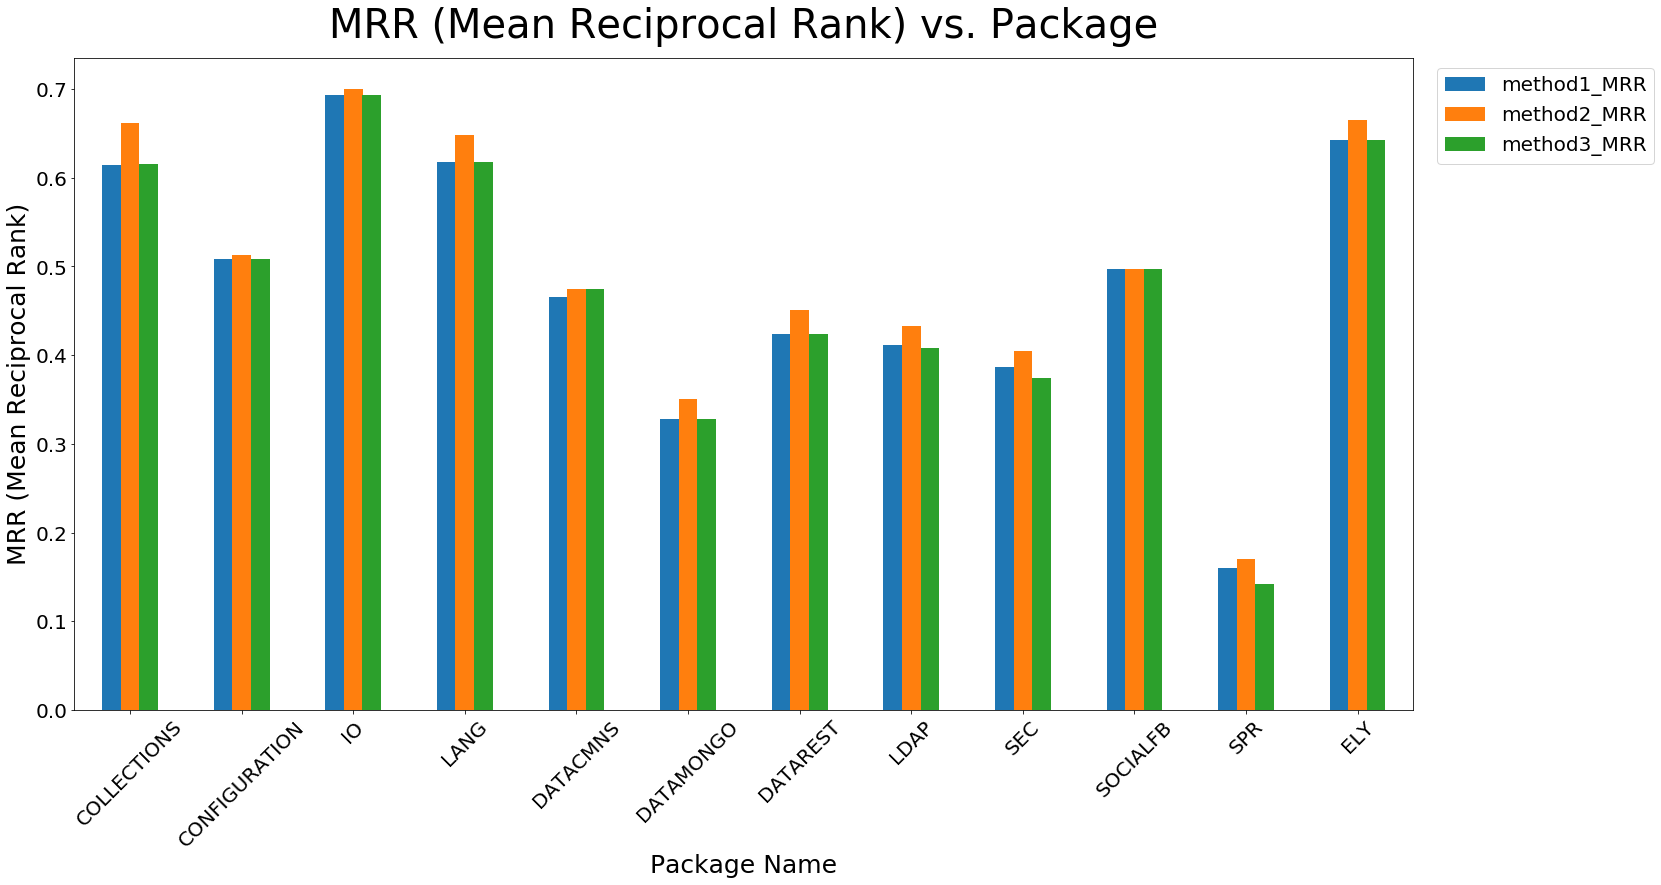

In [88]:
import matplotlib.pyplot as plt

fig = package_evaluations_diff[[
    'method1_MRR', 'method2_MRR', 'method3_MRR']].plot.bar(figsize=(24, 12), rot=45)
title: str = 'MRR (Mean Reciprocal Rank) vs. Package'
fig.set_title(title, fontsize=40, pad=20)
fig.set_xlabel('Package Name', fontsize=25)
fig.set_ylabel('MRR (Mean Reciprocal Rank)', fontsize=25)
fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
# plt.savefig(f'{title}.png')
plt.savefig(f'{title}.png', bbox_inches='tight')


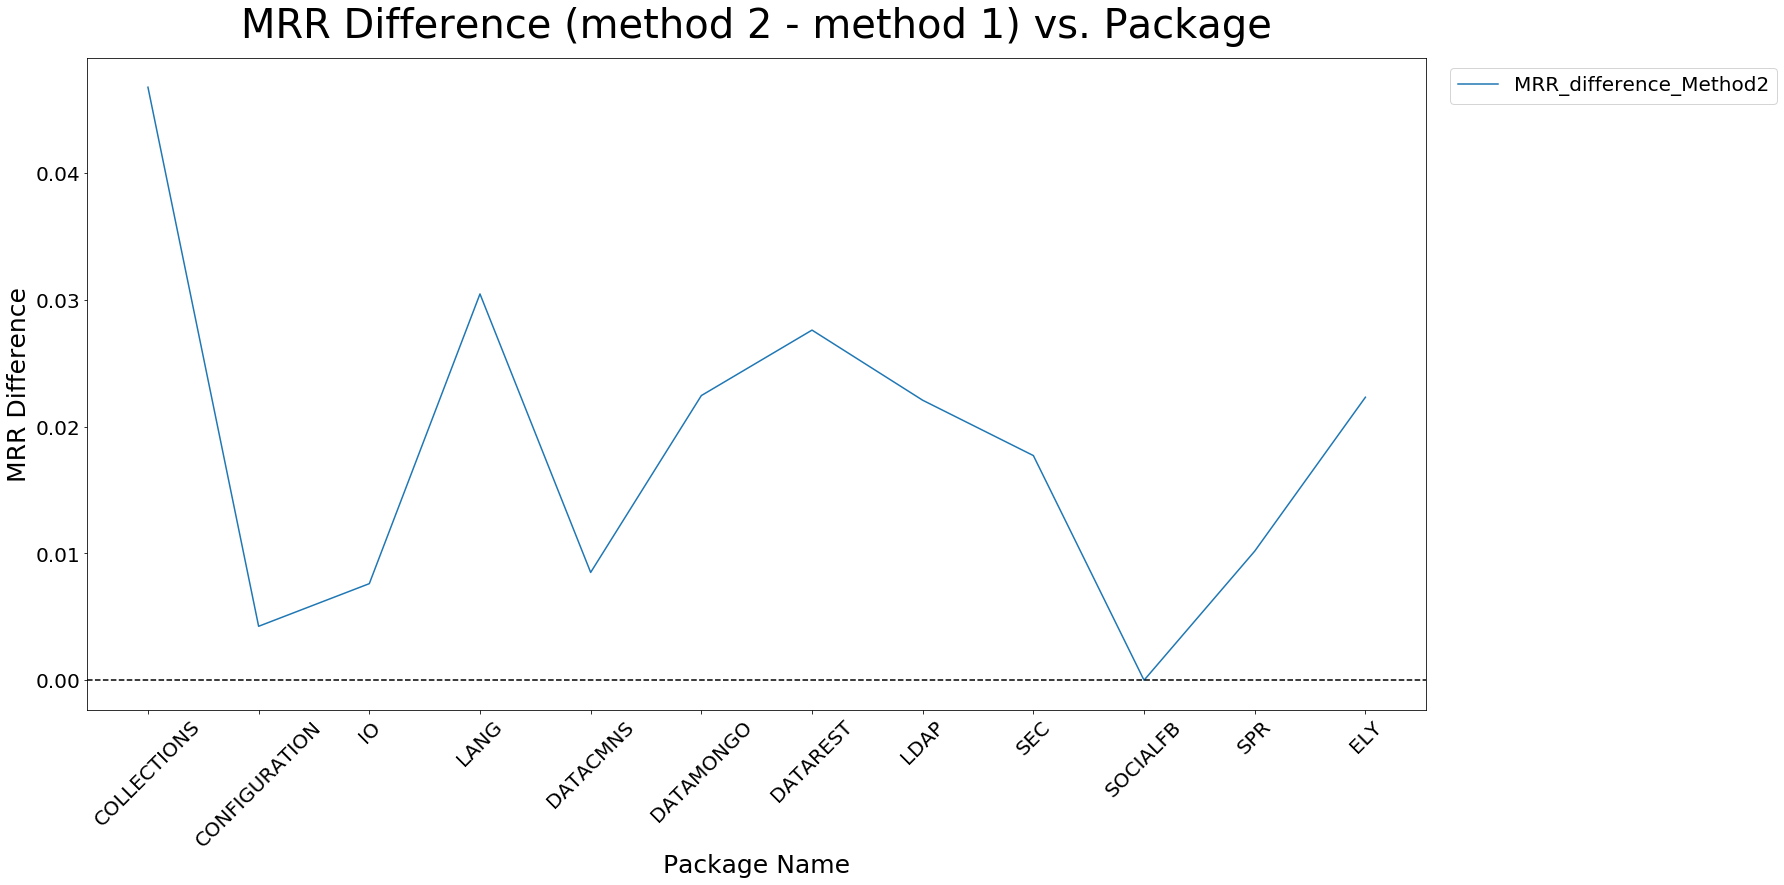

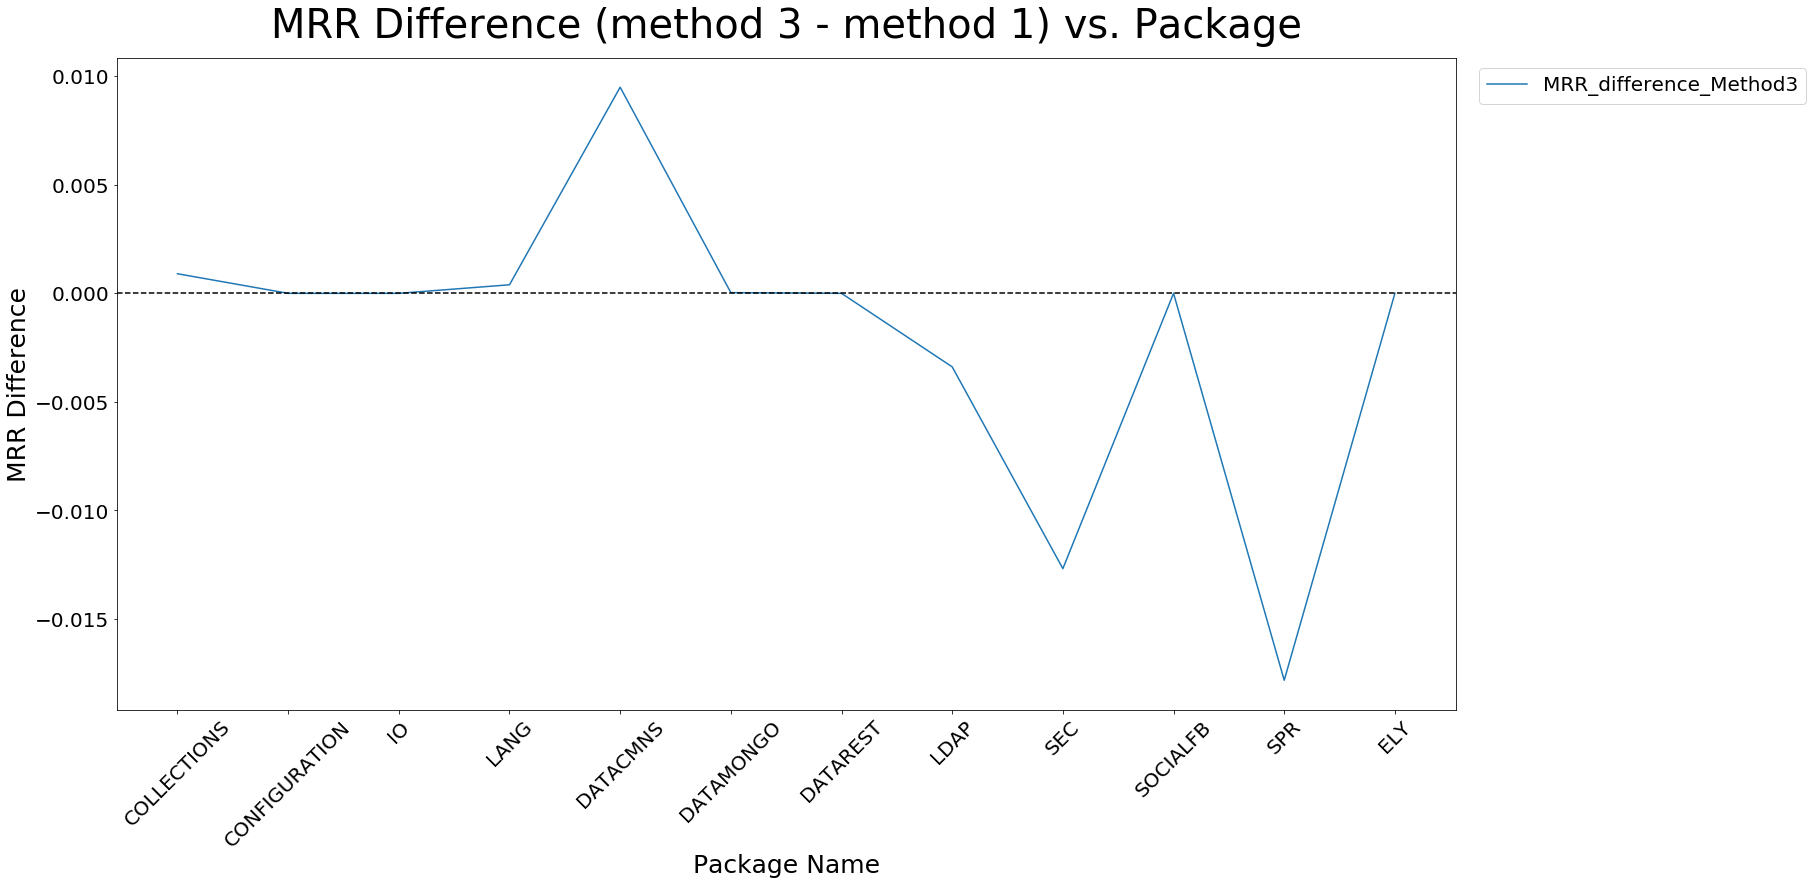

In [89]:
import matplotlib.ticker as ticker
for method_num in range(2,4):
    plt.figure()
    ax = plt.axes()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    fig = package_evaluations_diff[f'MRR_difference_Method{method_num}'].plot.line(
        figsize=(24, 12), rot=45, ax=ax)
    plt.axhline(y=0, linestyle='dashed', color='black')
    title: str = f'MRR Difference (method {method_num} - method 1) vs. Package'
    fig.set_title(title, fontsize=40, pad=20)
    fig.set_xlabel('Package Name', fontsize=25)
    fig.set_ylabel('MRR Difference', fontsize=25)
    fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
#     plt.savefig(f'{title}.png')
    plt.savefig(f'{title}.png', bbox_inches='tight')

### MAP Visualizations

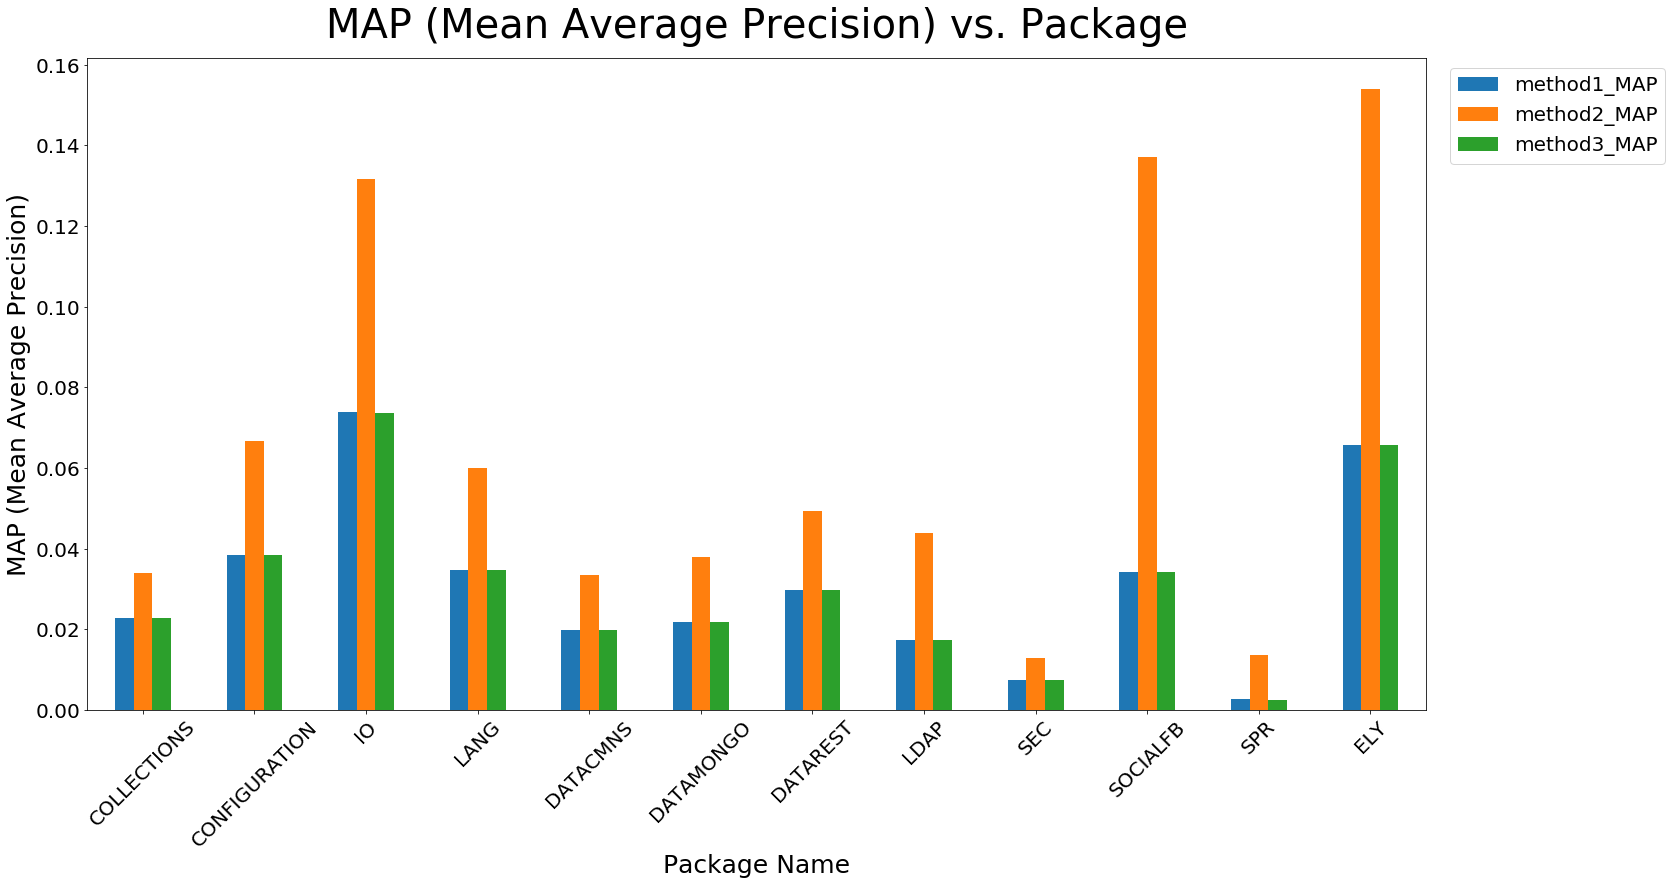

In [90]:
fig = package_evaluations_diff[[
    'method1_MAP', 'method2_MAP', 'method3_MAP']].plot.bar(
    figsize=(24, 12), rot=45)
title: str = 'MAP (Mean Average Precision) vs. Package'
fig.set_title(title, fontsize=40, pad=20)
fig.set_xlabel('Package Name', fontsize=25)
fig.set_ylabel('MAP (Mean Average Precision)', fontsize=25)
fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
# plt.savefig(f'{title}.png')
plt.savefig(f'{title}.png', bbox_inches='tight')


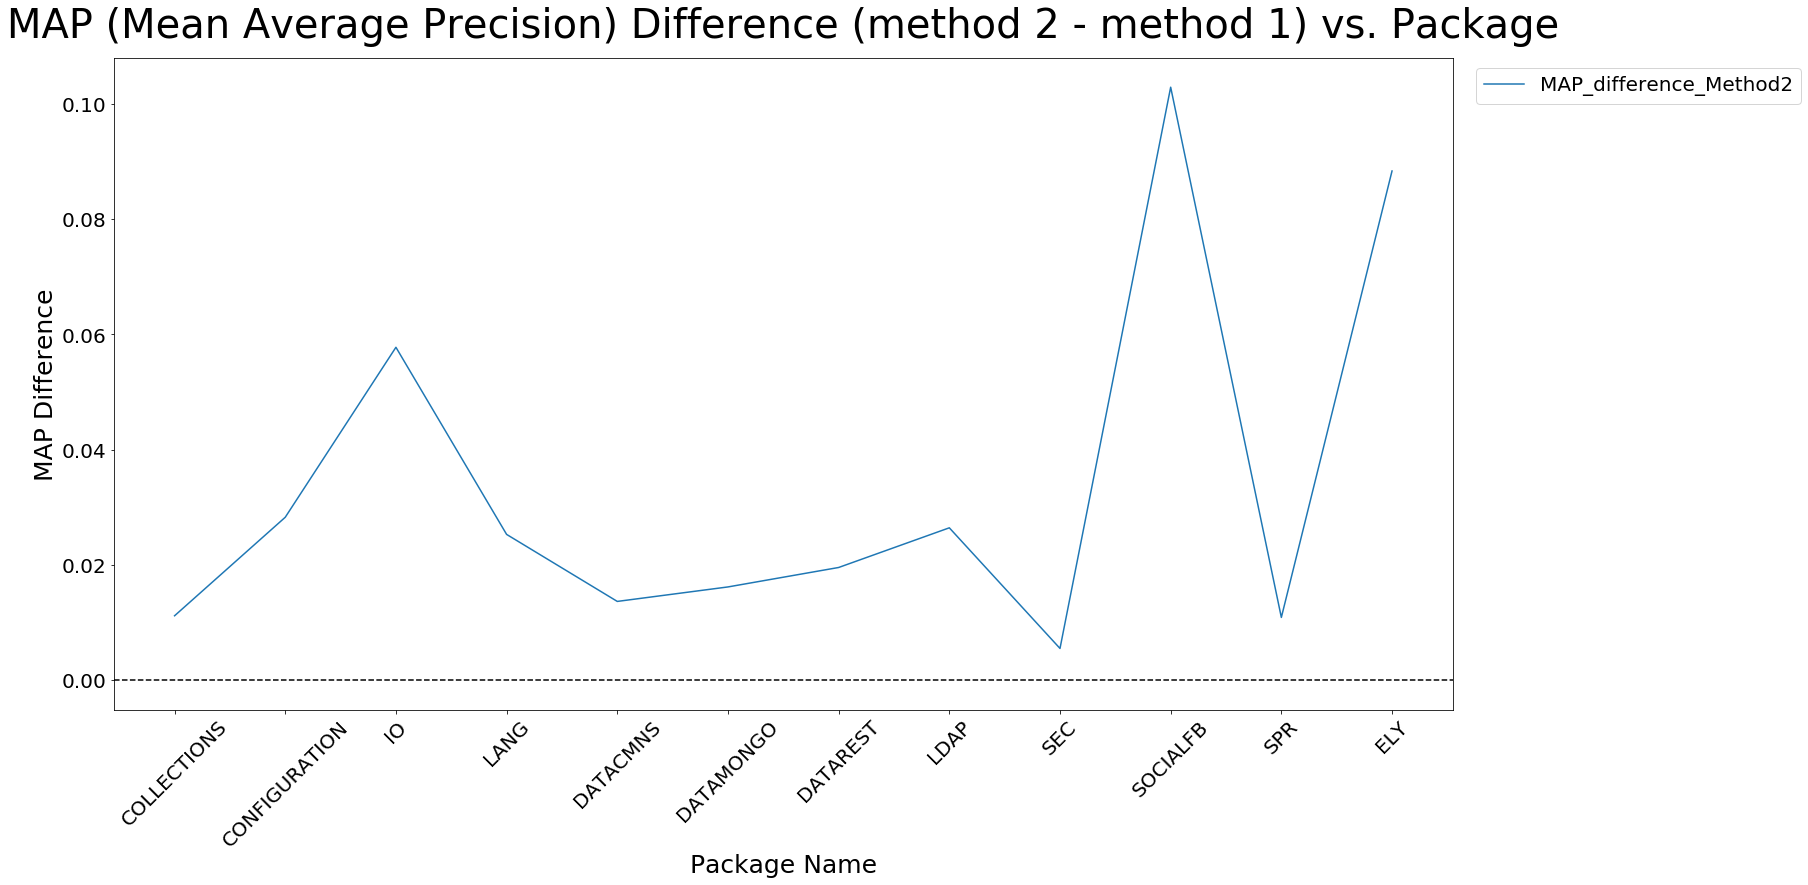

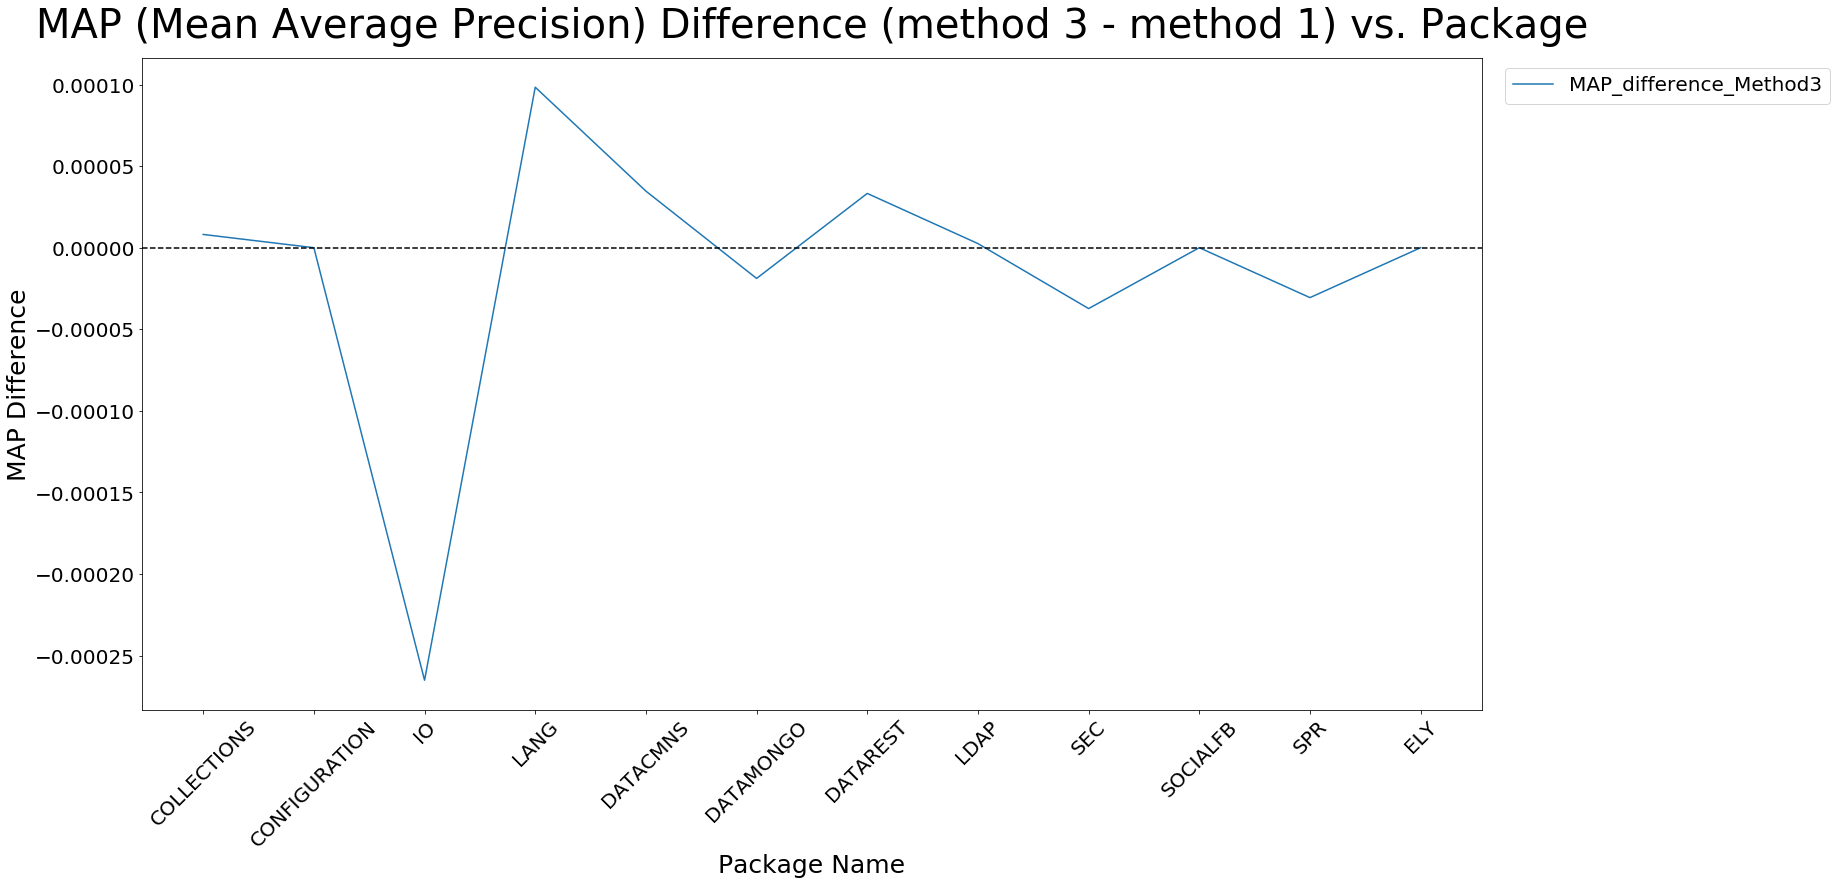

In [91]:
import matplotlib.ticker as ticker

for method_num in range(2,4):
    plt.figure()
    ax = plt.axes()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    fig = package_evaluations_diff[f'MAP_difference_Method{method_num}'].plot.line(
        figsize=(24, 12), rot=45, ax=ax)
    plt.axhline(y=0, linestyle='dashed', color='black')
    title: str = f'MAP (Mean Average Precision) Difference (method {method_num} - method 1) vs. Package'
    fig.set_title(title, fontsize=40, pad=20)
    fig.set_xlabel('Package Name', fontsize=25)
    fig.set_ylabel('MAP Difference', fontsize=25)
    fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
#     plt.savefig(f'{title}.png')
    plt.savefig(f'{title}.png', bbox_inches='tight')
